In [ ]:
!pip install kaggle

In [ ]:
!pip install tensorboardX

     |████████████████████████████████| 122kB 13.8MB/s 


In [ ]:
!mkdir /root/.kaggle

In [ ]:
!mkdir /content/.kaggle

In [ ]:
import json
token ={"username":"waterkingest","key":"cdf72ecbbd128e6d81f5d2ae47fdefd5"}
with open(r'//content//.kaggle//kaggle.json', 'w') as file:
    json.dump(token, file)

In [ ]:
!cp /content/.kaggle/kaggle.json /root/.kaggle/kaggle.json

In [ ]:
!kaggle config set -n path -v{/content}

- path is now set to: {/content}


In [ ]:
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
|

SyntaxError: ignored

In [ ]:
!kaggle datasets list -s water_bodies

ref                        title         size  lastUpdated          downloadCount  
-------------------------  ------------  ----  -------------------  -------------  
waterkingest/water-bodies  water_bodies   2GB  2021-04-27 15:15:21              2  


In [ ]:
!kaggle datasets download -d waterkingest/water-bodies -p /content

100% 1.56G/1.56G [00:30<00:00, 88.1MB/s]
100% 1.56G/1.56G [00:30<00:00, 54.7MB/s]


In [ ]:
!unzip /content/water-bodies.zip

流式输出内容被截断，只能显示最后 5000 行内容。
  inflating: VOCdevkit/VOC2007/SegmentationClass/H48F017017_clip2_61.png  
  inflating: VOCdevkit/VOC2007/SegmentationClass/H48F017017_clip2_62.png  
  inflating: VOCdevkit/VOC2007/SegmentationClass/H48F017017_clip2_63.png  
  inflating: VOCdevkit/VOC2007/SegmentationClass/H48F017017_clip2_64.png  
  inflating: VOCdevkit/VOC2007/SegmentationClass/H48F017017_clip2_7.png  
  inflating: VOCdevkit/VOC2007/SegmentationClass/H48F017017_clip2_8.png  
  inflating: VOCdevkit/VOC2007/SegmentationClass/H48F017017_clip2_9.png  
  inflating: VOCdevkit/VOC2007/SegmentationClass/H48F017017_clip3_1.png  
  inflating: VOCdevkit/VOC2007/SegmentationClass/H48F017017_clip3_10.png  
  inflating: VOCdevkit/VOC2007/SegmentationClass/H48F017017_clip3_11.png  
  inflating: VOCdevkit/VOC2007/SegmentationClass/H48F017017_clip3_12.png  
  inflating: VOCdevkit/VOC2007/SegmentationClass/H48F017017_clip3_13.png  
  inflating: VOCdevkit/VOC2007/SegmentationClass/H48F017017_clip3_14.png  
  

#数据增强

In [ ]:
import cv2
import random
import os
import numpy as np
from tqdm import tqdm
 
def gamma_transform(img, gamma):
    gamma_table = [np.power(x / 255.0, gamma) * 255.0 for x in range(256)]
    gamma_table = np.round(np.array(gamma_table)).astype(np.uint8)
    return cv2.LUT(img, gamma_table)

def random_gamma_transform(img, gamma_vari):
    log_gamma_vari = np.log(gamma_vari)
    alpha = np.random.uniform(-log_gamma_vari, log_gamma_vari)
    gamma = np.exp(alpha)
    return gamma_transform(img, gamma)
    

def rotate(xb,yb,angle,img_w,img_h):
    M_rotate = cv2.getRotationMatrix2D((img_w/2, img_h/2), angle, 1)
    xb = cv2.warpAffine(xb, M_rotate, (img_w, img_h))
    yb = cv2.warpAffine(yb, M_rotate, (img_w, img_h))
    return xb,yb
    
def blur(img):
    img = cv2.blur(img, (3, 3));
    return img

def add_noise(img):
    for i in range(200): #添加点噪声
        temp_x = np.random.randint(0,img.shape[0])
        temp_y = np.random.randint(0,img.shape[1])
        img[temp_x][temp_y] = 255
    return img
    
    
def data_augment(xb,yb,img_w,img_h):
    if np.random.random() < 0.25:
        xb,yb = rotate(xb,yb,90,img_w,img_h)
    if np.random.random() < 0.25:
        xb,yb = rotate(xb,yb,180,img_w,img_h)
    if np.random.random() < 0.25:
        xb,yb = rotate(xb,yb,270,img_w,img_h)
    if np.random.random() < 0.25:
        xb = cv2.flip(xb, 1)  # flipcode > 0：沿y轴翻转
        yb = cv2.flip(yb, 1)
        
    if np.random.random() < 0.25:
        xb = random_gamma_transform(xb,1.0)
        
    if np.random.random() < 0.25:
        xb = blur(xb)
    
    if np.random.random() < 0.2:
        xb = add_noise(xb)
        
    return xb,yb

def creat_dataset(image_num = 13000, mode = 'original'):
    print('creating dataset...')
    imagepath=r'/content/VOCdevkit/VOC2007/JPEGImages'
    labelpath=r'/content/VOCdevkit/VOC2007/SegmentationClass'
    temp_seg = os.listdir(labelpath)
    total_seg = []
    
    for seg in temp_seg:
        if seg.endswith(".png"):
            total_seg.append(seg)
    g_count = len(total_seg)
    need_creat=image_num-len(total_seg)
    for i in tqdm(range(need_creat)):
        randomfile=np.random.randint(0,len(total_seg))
        src_img = cv2.imread(imagepath +'/'+ total_seg[randomfile])  # 3 channels
        label_img = cv2.imread(labelpath +'/'+ total_seg[randomfile],cv2.IMREAD_GRAYSCALE)  # single channel 
        img_h,img_w,_ = src_img.shape 

        if mode == 'augment':
            src_roi,label_roi = data_augment(src_img,label_img,img_w,img_h)
        cv2.imwrite(('/content/VOCdevkit/VOC2007/JPEGImages/%d.png' % g_count),src_roi)
        cv2.imwrite(('/content/VOCdevkit/VOC2007/SegmentationClass/%d.png' % g_count),label_roi)
        g_count += 1

if __name__=='__main__':  
    creat_dataset(mode='augment')

  0%|          | 3/5576 [00:00<03:49, 24.29it/s]

creating dataset...


100%|██████████| 5576/5576 [01:56<00:00, 47.98it/s]


#生成训练计划


In [ ]:
import os
import random 
 
segfilepath=r'/content/VOCdevkit/VOC2007/SegmentationClass'
saveBasePath=r"/content/VOCdevkit/VOC2007/ImageSets/Segmentation"
 
trainval_percent=1
# 9:1
train_percent=0.9

temp_seg = os.listdir(segfilepath)
total_seg = []
for seg in temp_seg:
    if seg.endswith(".png"):
        total_seg.append(seg)

num=len(total_seg)  
list=range(num)  
tv=int(num*trainval_percent)  
tr=int(tv*train_percent)  
trainval= random.sample(list,tv)  
train=random.sample(trainval,tr)  
 
print("train and val size",tv)
print("traub suze",tr)
ftrainval = open(os.path.join(saveBasePath,'trainval.txt'), 'w')  
ftest = open(os.path.join(saveBasePath,'test.txt'), 'w')  
ftrain = open(os.path.join(saveBasePath,'train.txt'), 'w')  
fval = open(os.path.join(saveBasePath,'val.txt'), 'w')  
 
for i  in list:  
    name=total_seg[i][:-4]+'\n'  
    if i in trainval:  
        ftrainval.write(name)  
        if i in train:  
            ftrain.write(name)  
        else:  
            fval.write(name)  
    else:  
        ftest.write(name)  
  
ftrainval.close()  
ftrain.close()  
fval.close()  
ftest.close()


train and val size 13000
traub suze 11700


(501, 501, 3)


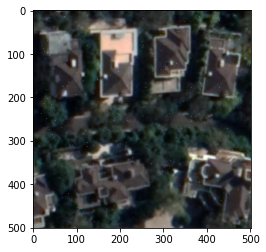

In [ ]:
import cv2
import matplotlib.pyplot as plt
img = cv2.imread("/content/VOCdevkit/VOC2007/JPEGImages/2118.png")
img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
print(img.shape)
plt.imshow(img)

In [ ]:
!pip install nvidia-ml-py3

# 监视显卡状态

In [ ]:
import pynvml
import time
pynvml.nvmlInit()
# handle = pynvml.nvmlDeviceGetHandleByIndex(0)
# meminfo = pynvml.nvmlDeviceGetMemoryInfo(handle)
# print(meminfo.used)
def printNvidiaGPU(gpu_id):
    # get GPU temperature
    gpu_device = pynvml.nvmlDeviceGetHandleByIndex(gpu_id)

    temperature = pynvml.nvmlDeviceGetTemperature(gpu_device, pynvml.NVML_TEMPERATURE_GPU)
    # get GPU memory total
    totalMemory = pynvml.nvmlDeviceGetMemoryInfo(gpu_device).total
    # get GPU memory used
    usedMemory = pynvml.nvmlDeviceGetMemoryInfo(gpu_device).used

    PersistenceMode = pynvml.nvmlDeviceGetPersistenceMode(gpu_device)
    UtilizationRates = pynvml.nvmlDeviceGetUtilizationRates(gpu_device)

    print("MemoryInfo：{0}M/{1}M，使用率：{2}%".format("%.1f" % (usedMemory / 1024 / 1024), "%.1f" % (totalMemory / 1024 / 1024), "%.1f" % (usedMemory/totalMemory*100)))
    print("Temperature：{0}摄氏度".format(temperature))
    # print("PersistenceMode: {0}".format(PersistenceMode))
    # print("UtilizationRates: {0}".format(UtilizationRates.gpu))

# 保存log

In [ ]:
import logging
import os
def get_logger(filename, verbosity=1, name=None):
    level_dict = {0: logging.DEBUG, 1: logging.INFO, 2: logging.WARNING}
    formatter = logging.Formatter(
        "[%(asctime)s][%(filename)s][line:%(lineno)d][%(levelname)s] %(message)s"
    )
    logger = logging.getLogger(name)
    logger.setLevel(level_dict[verbosity])

    fh = logging.FileHandler(filename, "w")
    fh.setFormatter(formatter)
    logger.addHandler(fh)

    sh = logging.StreamHandler()
    sh.setFormatter(formatter)
    logger.addHandler(sh)

    return logger
Train_Day='2021-05-23REsUnetD'#time.strftime("%Y-%m-%d", time.localtime())+'ChangeUnetDblock'
saveBasePath=r"/content/drive/MyDrive/MyUnet/"+Train_Day
SaveCheckPoint=r'/content/drive/MyDrive/MyUnet/'+Train_Day+'/checkpoint'
tensorlog=r"/content/drive/MyDrive/MyUnet/"+Train_Day+'/runs'
if not os.path.exists(saveBasePath):
    os.makedirs(saveBasePath)
if not os.path.exists(SaveCheckPoint):
    os.makedirs(SaveCheckPoint)
if not os.path.exists(tensorlog):
    os.makedirs(tensorlog)
logger = get_logger('/content/drive/MyDrive/MyUnet//'+Train_Day+'//'+Train_Day+'Train.log')
logger.info('start training!')

[2021-05-25 05:54:21,164][<ipython-input-14-bf0d07036fd7>][line:31][INFO] start training!


# 训练代码

In [ ]:
from random import shuffle
import numpy as np
import torch
import torch.nn as nn
import math
import torch.nn.functional as F
from PIL import Image
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
from matplotlib.colors import rgb_to_hsv, hsv_to_rgb
import cv2
def letterbox_image(image, label , size):
    label = Image.fromarray(np.array(label))
    '''resize image with unchanged aspect ratio using padding'''
    iw, ih = image.size
    w, h = size
    scale = min(w/iw, h/ih)
    nw = int(iw*scale)
    nh = int(ih*scale)

    image = image.resize((nw,nh), Image.BICUBIC)
    new_image = Image.new('RGB', size, (128,128,128))
    new_image.paste(image, ((w-nw)//2, (h-nh)//2))

    label = label.resize((nw,nh), Image.NEAREST)
    new_label = Image.new('L', size, (0))
    new_label.paste(label, ((w-nw)//2, (h-nh)//2))

    return new_image, new_label

def rand(a=0, b=1):
    return np.random.rand()*(b-a) + a

class DeeplabDataset(Dataset):
    def __init__(self,train_lines,image_size,num_classes,random_data):
        super(DeeplabDataset, self).__init__()

        self.train_lines = train_lines
        self.train_batches = len(train_lines)
        self.image_size = image_size
        self.num_classes = num_classes
        self.random_data = random_data

    def __len__(self):
        return self.train_batches

    def rand(self, a=0, b=1):
        return np.random.rand() * (b - a) + a

    def get_random_data(self, image, label, input_shape, jitter=.3, hue=.1, sat=1.5, val=1.5):
        label = Image.fromarray(np.array(label))

        h, w = input_shape
        # resize image
        rand_jit1 = rand(1-jitter,1+jitter)
        rand_jit2 = rand(1-jitter,1+jitter)
        new_ar = w/h * rand_jit1/rand_jit2

        scale = rand(0.5,1.5)
        if new_ar < 1:
            nh = int(scale*h)
            nw = int(nh*new_ar)
        else:
            nw = int(scale*w)
            nh = int(nw/new_ar)
        image = image.resize((nw,nh), Image.BICUBIC)
        label = label.resize((nw,nh), Image.NEAREST)
        label = label.convert("L")
        
        # flip image or not
        flip = rand()<.5
        if flip: 
            image = image.transpose(Image.FLIP_LEFT_RIGHT)
            label = label.transpose(Image.FLIP_LEFT_RIGHT)
        
        # place image
        dx = int(rand(0, w-nw))
        dy = int(rand(0, h-nh))
        new_image = Image.new('RGB', (w,h), (128,128,128))
        new_label = Image.new('L', (w,h), (0))
        new_image.paste(image, (dx, dy))
        new_label.paste(label, (dx, dy))
        image = new_image
        label = new_label

        # distort image 扭曲图片
        hue = rand(-hue, hue)
        sat = rand(1, sat) if rand()<.5 else 1/rand(1, sat)
        val = rand(1, val) if rand()<.5 else 1/rand(1, val)
        x = cv2.cvtColor(np.array(image,np.float32)/255, cv2.COLOR_RGB2HSV)
        x[..., 0] += hue*360
        x[..., 0][x[..., 0]>1] -= 1
        x[..., 0][x[..., 0]<0] += 1
        x[..., 1] *= sat
        x[..., 2] *= val
        x[x[:,:, 0]>360, 0] = 360
        x[:, :, 1:][x[:, :, 1:]>1] = 1
        x[x<0] = 0
        image_data = cv2.cvtColor(x, cv2.COLOR_HSV2RGB)*255
        return image_data,label

    def __getitem__(self, index):
        if index == 0:
            shuffle(self.train_lines)
            
        annotation_line = self.train_lines[index]
        name = annotation_line.split()[0]
        # 从文件中读取图像
        jpg = Image.open(r"/content/VOCdevkit/VOC2007/JPEGImages" + '/' + name + ".png")
        png = Image.open(r"/content/VOCdevkit/VOC2007/SegmentationClass" + '/' + name + ".png")
        if self.random_data:
            jpg, png = self.get_random_data(jpg,png,(int(self.image_size[1]),int(self.image_size[0])))
        else:
            jpg, png = letterbox_image(jpg, png, (int(self.image_size[1]),int(self.image_size[0])))

        # 从文件中读取图像
        png = np.array(png)
        if self.num_classes==2:
            png[png==255]=1
        png[png >= self.num_classes] = self.num_classes
        # print(png)
        # return False
        # 转化成one_hot的形式
#         print(png.shape)
#         print(self.num_classes+1)
#         print(png.reshape([-1]))
#         print(type(png))
        seg_labels = np.eye(self.num_classes+1)[png.reshape([-1])]
        seg_labels = seg_labels.reshape((int(self.image_size[1]),int(self.image_size[0]),self.num_classes+1))

        jpg = np.transpose(np.array(jpg),[2,0,1])/255

        return jpg, png, seg_labels


# DataLoader中collate_fn使用
def deeplab_dataset_collate(batch):
    images = []
    pngs = []
    seg_labels = []
    for img, png, labels in batch:
        images.append(img)
        pngs.append(png)
        seg_labels.append(labels)
    images = np.array(images)
    pngs = np.array(pngs)
    seg_labels = np.array(seg_labels)
    return images, pngs, seg_labels
def f_score(inputs, target, beta=1, smooth = 1e-5, threhold = 0.5):
    n, c, h, w = inputs.size()
    nt, ht, wt, ct = target.size()
    
    if h != ht and w != wt:
        inputs = F.interpolate(inputs, size=(ht, wt), mode="bilinear", align_corners=True)
    temp_inputs = torch.softmax(inputs.transpose(1, 2).transpose(2, 3).contiguous().view(n, -1, c),-1)
    temp_target = target.view(n, -1, ct)

    #--------------------------------------------#
    #   计算dice系数
    #--------------------------------------------#
    temp_inputs = torch.gt(temp_inputs,threhold).float()
    tp = torch.sum(temp_target[...,:-1] * temp_inputs, axis=[0,1])
    fp = torch.sum(temp_inputs                       , axis=[0,1]) - tp
    fn = torch.sum(temp_target[...,:-1]              , axis=[0,1]) - tp

    score = ((1 + beta ** 2) * tp + smooth) / ((1 + beta ** 2) * tp + beta ** 2 * fn + fp + smooth)
    score = torch.mean(score)
    return score

#  自己改的Unet

In [ ]:
import torch
import torch.nn as nn
from torchvision.models.utils import load_state_dict_from_url

class VGG(nn.Module):
    def __init__(self, features, num_classes=1000):
        super(VGG, self).__init__()
        self.features = features
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )
        self._initialize_weights()

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)


def make_layers(cfg, batch_norm=False, in_channels = 3):
    layers = []
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)
# 512,512,3 -> 512,512,64 -> 256,256,64 -> 256,256,128 -> 128,128,128 -> 128,128,256 -> 64,64,256
# 64,64,512 -> 32,32,512 -> 32,32,512
cfgs = {
    'D': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M']
}


def VGG16(pretrained, in_channels, **kwargs):
    model = VGG(make_layers(cfgs["D"], batch_norm = False, in_channels = in_channels), **kwargs)
    if pretrained:
        state_dict = load_state_dict_from_url("https://download.pytorch.org/models/vgg16-397923af.pth", model_dir="./model_data")
        model.load_state_dict(state_dict)
    
    del model.avgpool
    del model.classifier
    return model

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary

from functools import partial

nonlinearity = partial(F.relu,inplace=True)

class Dblock_more_dilate(nn.Module):
    def __init__(self,channel):
        super(Dblock_more_dilate, self).__init__()
        self.dilate1 = nn.Conv2d(channel, channel, kernel_size=3, dilation=1, padding=1)
        self.dilate2 = nn.Conv2d(channel, channel, kernel_size=3, dilation=2, padding=2)
        self.dilate3 = nn.Conv2d(channel, channel, kernel_size=3, dilation=4, padding=4)
        self.dilate4 = nn.Conv2d(channel, channel, kernel_size=3, dilation=8, padding=8)
        self.dilate5 = nn.Conv2d(channel, channel, kernel_size=3, dilation=16, padding=16)
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
                if m.bias is not None:
                    m.bias.data.zero_()
                    
    def forward(self, x):
        dilate1_out = nonlinearity(self.dilate1(x))
        dilate2_out = nonlinearity(self.dilate2(dilate1_out))
        dilate3_out = nonlinearity(self.dilate3(dilate2_out))
        dilate4_out = nonlinearity(self.dilate4(dilate3_out))
        dilate5_out = nonlinearity(self.dilate5(dilate4_out))
        out = x + dilate1_out + dilate2_out + dilate3_out + dilate4_out + dilate5_out
        return out
import torchvision.utils as vutils
# from tensorboardX import SummaryWriter
# # 定义Summary_Writer
# writer = SummaryWriter('./runs') 

class unetUp(nn.Module):
    def __init__(self, in_size, out_size):
        super(unetUp, self).__init__()
        self.conv1 = nn.Conv2d(in_size, out_size, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(out_size, out_size, kernel_size=3, padding=1)
        self.up = nn.UpsamplingBilinear2d(scale_factor=2)

    def forward(self, inputs1, inputs2):

        outputs = torch.cat([inputs1, self.up(inputs2)], 1)
        outputs = self.conv1(outputs)
        outputs = self.conv2(outputs)
        return outputs


class Unet(nn.Module):
    def addimage(self,images,name):#可视化featuremap
        if self.record:
            x1 = images.transpose(0, 1)  # C，B, H, W  ---> B，C, H, W
            print(x1.size())
            img_grid = vutils.make_grid(x1, normalize=True, scale_each=True, nrow=4)  # normalize进行归一化处理
            writer.add_image(f'{name}_feature_maps', img_grid, global_step=0)
            print('finish')
        else:
            pass
    def __init__(self, num_classes=21, in_channels=3, pretrained=False,record=False):
        super(Unet, self).__init__()
        self.vgg = VGG16(pretrained=pretrained,in_channels=in_channels)
        in_filters = [192, 384, 768, 1024]
        out_filters = [64, 128, 256, 512]
        self.record=record
        # upsampling
        # 64,64,512
        self.up_concat4 = unetUp(in_filters[3], out_filters[3])
        # 128,128,256
        self.up_concat3 = unetUp(in_filters[2], out_filters[2])
        # 256,256,128
        self.up_concat2 = unetUp(in_filters[1], out_filters[1])
        # 512,512,64
        self.up_concat1 = unetUp(in_filters[0], out_filters[0])
        self.Dblock=Dblock_more_dilate(512)
        # final conv (without any concat)
        self.final = nn.Conv2d(out_filters[0], num_classes, 1)

    def forward(self, inputs):
        feat1 = self.vgg.features[  :4 ](inputs)
        self.addimage(feat1,'vgg1')
        feat2 = self.vgg.features[4 :9 ](feat1)
        self.addimage(feat2,'vgg2')
        feat3 = self.vgg.features[9 :16](feat2)
        self.addimage(feat3,'vgg3')
        feat4 = self.vgg.features[16:23](feat3)
        self.addimage(feat4,'vgg4')
        feat5 = self.vgg.features[23:-1](feat4)
        self.addimage(feat5,'vgg5')
        feat5=self.Dblock(feat5)
        up4 = self.up_concat4(feat4, feat5)
        self.addimage(up4,'up4')
        up3 = self.up_concat3(feat3, up4)
        self.addimage(up3,'up3')
        up2 = self.up_concat2(feat2, up3)
        self.addimage(up2,'up2')
        up1 = self.up_concat1(feat1, up2)
        self.addimage(up1,'up1')

        final = self.final(up1)
        # writer.close()
        return final

    def _initialize_weights(self, *stages):
        for modules in stages:
            for module in modules.modules():
                if isinstance(module, nn.Conv2d):
                    nn.init.kaiming_normal_(module.weight)
                    if module.bias is not None:
                        module.bias.data.zero_()
                elif isinstance(module, nn.BatchNorm2d):
                    module.weight.data.fill_(1)
                    module.bias.data.zero_()



#卷积核为3

In [ ]:
import torch
import torch.nn as nn
from torchvision.models.utils import load_state_dict_from_url

class VGG(nn.Module):
    def __init__(self, features, num_classes=1000):
        super(VGG, self).__init__()
        self.features = features
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )
        self._initialize_weights()

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)


def make_layers(cfg, batch_norm=False, in_channels = 3):
    layers = []
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)
# 512,512,3 -> 512,512,64 -> 256,256,64 -> 256,256,128 -> 128,128,128 -> 128,128,256 -> 64,64,256
# 64,64,512 -> 32,32,512 -> 32,32,512
cfgs = {
    'D': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M']
}


def VGG16(pretrained, in_channels, **kwargs):
    model = VGG(make_layers(cfgs["D"], batch_norm = False, in_channels = in_channels), **kwargs)
    if pretrained:
        state_dict = load_state_dict_from_url("https://download.pytorch.org/models/vgg16-397923af.pth", model_dir="./model_data")
        model.load_state_dict(state_dict)
    
    del model.avgpool
    del model.classifier
    return model

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
# from torchsummary import summary
import torchvision.utils as vutils
# from tensorboardX import SummaryWriter
# # 定义Summary_Writer
# writer = SummaryWriter('./runs') 

class unetUp(nn.Module):
    def __init__(self, in_size, out_size):
        super(unetUp, self).__init__()
        self.conv1 = nn.Conv2d(in_size, out_size, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(out_size, out_size, kernel_size=3, padding=1)
        self.up = nn.UpsamplingBilinear2d(scale_factor=2)

    def forward(self, inputs1, inputs2):

        outputs = torch.cat([inputs1, self.up(inputs2)], 1)
        outputs = self.conv1(outputs)
        outputs = self.conv2(outputs)
        return outputs


class Unet(nn.Module):
    def addimage(self,images,name):#可视化featuremap
        if self.record:
            x1 = images.transpose(0, 1)  # C，B, H, W  ---> B，C, H, W
            print(x1.size())
            img_grid = vutils.make_grid(x1, normalize=True, scale_each=True, nrow=4)  # normalize进行归一化处理
            writer.add_image(f'{name}_feature_maps', img_grid, global_step=0)
            print('finish')
        else:
            pass
    def __init__(self, num_classes=2, in_channels=3, pretrained=False,record=False):
        super(Unet, self).__init__()
        self.vgg = VGG16(pretrained=pretrained,in_channels=in_channels)
        in_filters = [192, 384, 768, 1024]
        out_filters = [64, 128, 256, 512]
        self.record=record
        # upsampling
        # 64,64,512
        self.up_concat4 = unetUp(in_filters[3], out_filters[3])
        # 128,128,256
        self.up_concat3 = unetUp(in_filters[2], out_filters[2])
        # 256,256,128
        self.up_concat2 = unetUp(in_filters[1], out_filters[1])
        # 512,512,64
        self.up_concat1 = unetUp(in_filters[0], out_filters[0])

        # final conv (without any concat)
        self.final = nn.Conv2d(out_filters[0], num_classes, 1)

    def forward(self, inputs):
        feat1 = self.vgg.features[  :4 ](inputs)
        self.addimage(feat1,'vgg1')
        feat2 = self.vgg.features[4 :9 ](feat1)
        self.addimage(feat2,'vgg2')
        feat3 = self.vgg.features[9 :16](feat2)
        self.addimage(feat3,'vgg3')
        feat4 = self.vgg.features[16:23](feat3)
        self.addimage(feat4,'vgg4')
        feat5 = self.vgg.features[23:-1](feat4)
        self.addimage(feat5,'vgg5')
        up4 = self.up_concat4(feat4, feat5)
        self.addimage(up4,'up4')
        up3 = self.up_concat3(feat3, up4)
        self.addimage(up3,'up3')
        up2 = self.up_concat2(feat2, up3)
        self.addimage(up2,'up2')
        up1 = self.up_concat1(feat1, up2)
        self.addimage(up1,'up1')

        final = self.final(up1)
        # writer.close()
        return final

    def _initialize_weights(self, *stages):
        for modules in stages:
            for module in modules.modules():
                if isinstance(module, nn.Conv2d):
                    nn.init.kaiming_normal_(module.weight)
                    if module.bias is not None:
                        module.bias.data.zero_()
                elif isinstance(module, nn.BatchNorm2d):
                    module.weight.data.fill_(1)
                    module.bias.data.zero_()




---



#卷积核为5


In [ ]:
import torch
import torch.nn as nn
from torchvision.models.utils import load_state_dict_from_url

class VGG(nn.Module):
    def __init__(self, features, num_classes=1000):
        super(VGG, self).__init__()
        self.features = features
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )
        self._initialize_weights()

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)


def make_layers(cfg, batch_norm=False, in_channels = 3):
    layers = []
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=5, padding=2)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)
# 512,512,3 -> 512,512,64 -> 256,256,64 -> 256,256,128 -> 128,128,128 -> 128,128,256 -> 64,64,256
# 64,64,512 -> 32,32,512 -> 32,32,512
cfgs = {
    'D': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M']
}


def VGG16(pretrained, in_channels, **kwargs):
    model = VGG(make_layers(cfgs["D"], batch_norm = False, in_channels = in_channels), **kwargs)
    if pretrained:
        state_dict = load_state_dict_from_url("https://download.pytorch.org/models/vgg16-397923af.pth", model_dir="./model_data")
        model.load_state_dict(state_dict)
    
    del model.avgpool
    del model.classifier
    return model

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
# from torchsummary import summary
import torchvision.utils as vutils
# from tensorboardX import SummaryWriter
# # 定义Summary_Writer
# writer = SummaryWriter('./runs') 

class unetUp(nn.Module):
    def __init__(self, in_size, out_size):
        super(unetUp, self).__init__()
        self.conv1 = nn.Conv2d(in_size, out_size, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(out_size, out_size, kernel_size=5, padding=2)
        self.up = nn.UpsamplingBilinear2d(scale_factor=2)

    def forward(self, inputs1, inputs2):

        outputs = torch.cat([inputs1, self.up(inputs2)], 1)
        outputs = self.conv1(outputs)
        outputs = self.conv2(outputs)
        return outputs


class Unet(nn.Module):
    def addimage(self,images,name):#可视化featuremap
        if self.record:
            x1 = images.transpose(0, 1)  # C，B, H, W  ---> B，C, H, W
            print(x1.size())
            img_grid = vutils.make_grid(x1, normalize=True, scale_each=True, nrow=4)  # normalize进行归一化处理
            writer.add_image(f'{name}_feature_maps', img_grid, global_step=0)
            print('finish')
        else:
            pass
    def __init__(self, num_classes=2, in_channels=3, pretrained=False,record=False):
        super(Unet, self).__init__()
        self.vgg = VGG16(pretrained=pretrained,in_channels=in_channels)
        in_filters = [192, 384, 768, 1024]
        out_filters = [64, 128, 256, 512]
        self.record=record
        # upsampling
        # 64,64,512
        self.up_concat4 = unetUp(in_filters[3], out_filters[3])
        # 128,128,256
        self.up_concat3 = unetUp(in_filters[2], out_filters[2])
        # 256,256,128
        self.up_concat2 = unetUp(in_filters[1], out_filters[1])
        # 512,512,64
        self.up_concat1 = unetUp(in_filters[0], out_filters[0])

        # final conv (without any concat)
        self.final = nn.Conv2d(out_filters[0], num_classes, 1)

    def forward(self, inputs):
        feat1 = self.vgg.features[  :4 ](inputs)
        self.addimage(feat1,'vgg1')
        feat2 = self.vgg.features[4 :9 ](feat1)
        self.addimage(feat2,'vgg2')
        feat3 = self.vgg.features[9 :16](feat2)
        self.addimage(feat3,'vgg3')
        feat4 = self.vgg.features[16:23](feat3)
        self.addimage(feat4,'vgg4')
        feat5 = self.vgg.features[23:-1](feat4)
        self.addimage(feat5,'vgg5')
        up4 = self.up_concat4(feat4, feat5)
        self.addimage(up4,'up4')
        up3 = self.up_concat3(feat3, up4)
        self.addimage(up3,'up3')
        up2 = self.up_concat2(feat2, up3)
        self.addimage(up2,'up2')
        up1 = self.up_concat1(feat1, up2)
        self.addimage(up1,'up1')

        final = self.final(up1)
        # writer.close()
        return final

    def _initialize_weights(self, *stages):
        for modules in stages:
            for module in modules.modules():
                if isinstance(module, nn.Conv2d):
                    nn.init.kaiming_normal_(module.weight)
                    if module.bias is not None:
                        module.bias.data.zero_()
                elif isinstance(module, nn.BatchNorm2d):
                    module.weight.data.fill_(1)
                    module.bias.data.zero_()




---



#改进Unet—+dlink


In [ ]:
import torch
import torch.nn as nn
from torchvision.models.utils import load_state_dict_from_url

class VGG(nn.Module):
    def __init__(self, features, num_classes=1000):
        super(VGG, self).__init__()
        self.features = features
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )
        self._initialize_weights()

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)


def make_layers(cfg, batch_norm=False, in_channels = 3):
    layers = []
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)
# 512,512,3 -> 512,512,64 -> 256,256,64 -> 256,256,128 -> 128,128,128 -> 128,128,256 -> 64,64,256
# 64,64,512 -> 32,32,512 -> 32,32,512
cfgs = {
    'D': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M']
}


def VGG16(pretrained, in_channels, **kwargs):
    model = VGG(make_layers(cfgs["D"], batch_norm = False, in_channels = in_channels), **kwargs)
    if pretrained:
        state_dict = load_state_dict_from_url("https://download.pytorch.org/models/vgg16-397923af.pth", model_dir="./model_data")
        model.load_state_dict(state_dict)
    
    del model.avgpool
    del model.classifier
    return model

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
from functools import partial
from torchvision import models

nonlinearity = partial(F.relu,inplace=True)

class Dblock_more_dilate(nn.Module):
    def __init__(self,channel):
        super(Dblock_more_dilate, self).__init__()
        self.dilate1 = nn.Conv2d(channel, channel, kernel_size=3, dilation=1, padding=1)
        self.dilate2 = nn.Conv2d(channel, channel, kernel_size=3, dilation=2, padding=2)
        self.dilate3 = nn.Conv2d(channel, channel, kernel_size=3, dilation=4, padding=4)
        self.dilate4 = nn.Conv2d(channel, channel, kernel_size=3, dilation=8, padding=8)
        self.dilate5 = nn.Conv2d(channel, channel, kernel_size=3, dilation=16, padding=16)
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
                if m.bias is not None:
                    m.bias.data.zero_()
                    
    def forward(self, x):
        dilate1_out = nonlinearity(self.dilate1(x))
        dilate2_out = nonlinearity(self.dilate2(dilate1_out))
        dilate3_out = nonlinearity(self.dilate3(dilate2_out))
        dilate4_out = nonlinearity(self.dilate4(dilate3_out))
        dilate5_out = nonlinearity(self.dilate5(dilate4_out))
        out = x + dilate1_out + dilate2_out + dilate3_out + dilate4_out + dilate5_out
        return out
import torchvision.utils as vutils
# from tensorboardX import SummaryWriter
# # 定义Summary_Writer
# writer = SummaryWriter('./runs') 
class unetUp0(nn.Module):
    def __init__(self, in_size, out_size):
        super(unetUp0, self).__init__()
        self.conv1 = nn.Conv2d(in_size, out_size, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(out_size, out_size, kernel_size=3, padding=1)
        self.up = nn.UpsamplingBilinear2d(scale_factor=2)

    def forward(self, inputs1, inputs2):

        outputs = torch.cat([inputs1, self.up(inputs2)], 1)
        outputs = self.conv1(outputs)
        outputs = self.conv2(outputs)
        return outputs
class unetUp(nn.Module):
    def __init__(self, in_size, out_size):
        super(unetUp, self).__init__()
        self.conv1 = nn.Conv2d(in_size, out_size, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(out_size, out_size, kernel_size=3, padding=1)
        self.up = nn.UpsamplingBilinear2d(scale_factor=2)

    def forward(self, inputs1, inputs2,inputs3):

        outputs = torch.cat([inputs1, self.up(inputs2)], 1)
        outputs = torch.cat([outputs, inputs3], 1)
        outputs = self.conv1(outputs)
        outputs = self.conv2(outputs)
        return outputs
class unetDown(nn.Module):
    def __init__(self, in_size, out_size):
        super(unetDown, self).__init__()
        self.layer1 = nn.Sequential(
                nn.Conv2d(in_size, out_size, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_size),
                nn.ReLU(True),
            )
        self.layer2 = nn.Sequential(
                nn.Conv2d(out_size, out_size, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_size),
                nn.ReLU(True),
            )
    def forward(self, inputs1):
        outputs =self.layer1(inputs1)
        outputs =self.layer2(outputs) 
        # outputs = self.conv2(outputs)
        return outputs
class unetDown3(nn.Module):
    def __init__(self, in_size, out_size):
        super(unetDown3, self).__init__()
        self.layer1 = nn.Sequential(
                nn.Conv2d(in_size, out_size, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_size),
                nn.ReLU(True),
            )
        self.layer2 = nn.Sequential(
                nn.Conv2d(out_size, out_size, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_size),
                nn.ReLU(True),
            )
        self.Drop=nn.Dropout(0.5)
    def forward(self, inputs1):
        outputs =self.layer1(inputs1)
        outputs =self.layer2(outputs) 
        outputs=self.Drop(outputs)
        # outputs = self.conv2(outputs)
        return outputs
class MyUnet3(nn.Module):
    def addimage(self,images,name):#可视化featuremap
        if self.record:
            x1 = images.transpose(0, 1)  # C，B, H, W  ---> B，C, H, W
            print(x1.size())
            img_grid = vutils.make_grid(x1, normalize=True, scale_each=True, nrow=4)  # normalize进行归一化处理
            writer.add_image(f'{name}_feature_maps', img_grid, global_step=0)
            print('finish')
        else:
            pass
    def __init__(self, num_classes=21, in_channels=3, pretrained=False,record=False):
        super(MyUnet3, self).__init__()
        resnet = models.resnet34(pretrained=True)
        self.vgg = VGG16(pretrained=pretrained,in_channels=in_channels)
        # self.vgg = VGG16(pretrained=pretrained,in_channels=in_channels)
        in_filters = [192, 512, 1024, 1536]
        out_filters = [64, 128, 256, 512]
        self.record=record
        self.encoder1 = resnet.layer1
        self.encodecov1=nn.Sequential(
                nn.Conv2d(out_filters[0],out_filters[1], kernel_size=3, padding=1),   
                nn.BatchNorm2d(out_filters[1]),
                nn.ReLU(True),
            )
        self.encoder2 = resnet.layer2
        self.encodecov2=nn.Sequential(
                nn.Conv2d(out_filters[1],out_filters[2], kernel_size=3, padding=1),
                nn.BatchNorm2d(out_filters[2]),
                nn.ReLU(True),
            )
        self.encoder3 = resnet.layer3
        self.encodecov3=nn.Sequential(
                nn.Conv2d(out_filters[2],out_filters[3], kernel_size=3, padding=1),
                nn.BatchNorm2d(out_filters[3]),
                nn.ReLU(True),
            )
        self.encoder4 = resnet.layer4
        self.Down1 = unetDown(in_channels, out_filters[0])
        self.Down5 = unetDown3(out_filters[3], out_filters[3])
        self.maxp=nn.MaxPool2d(kernel_size=2, stride=2)
        # upsampling
        # 64,64,512
        self.up_concat4 = unetUp(in_filters[3], out_filters[3])
        # 128,128,256
        self.up_concat3 = unetUp(in_filters[2], out_filters[2])
        # 256,256,128
        self.up_concat2 = unetUp(in_filters[1], out_filters[1])
        # 512,512,64
        self.up_concat1 = unetUp0(in_filters[0], out_filters[0])
        self.Dblock=Dblock_more_dilate(512)
        # final conv (without any concat)
        self.final = nn.Conv2d(out_filters[0], num_classes, 1)

    def forward(self, inputs):
        feat1 = self.vgg.features[  :4 ](inputs)
        feat2 = self.vgg.features[4 :7 ](feat1)
        feat21= self.vgg.features[7 :9 ](feat2)#128,128,128
        feat3 = self.vgg.features[9 :12](feat21)
        feat31 = self.vgg.features[12 :16](feat3)
        feat4 = self.vgg.features[16:19](feat31)
        feate1=self.Down1(inputs)#64,512,512
        feate11=self.maxp(feate1)#64,256,256
        e1 = self.encoder1(feate11)#64,256,256
        e11=self.encodecov1(e1)#128,256,256
        e2 = self.encoder2(e1)#128,128,128
        e21=self.encodecov2(e2)#256，128，128
        e3 = self.encoder3(e2)#256，64，64
        e31=self.encodecov3(e3)#512，64，64
        e4 = self.encoder4(e3)#512，32，32
        feate5=self.Down5(e4)
        # feat5=self.Dblock(e4)#512，32，32

        up4 = self.up_concat4(e31, feate5,feat4)
        # self.addimage(up4,'up4')
        up3 = self.up_concat3(e21, up4,feat3)
        # self.addimage(up3,'up3')
        up2 = self.up_concat2(e11, up3,feat2)
        # self.addimage(up2,'up2')
        up1 = self.up_concat1(feate1, up2)
        # self.addimage(up1,'up1')

        final = self.final(up1)
        # writer.close()
        return final

    def _initialize_weights(self, *stages):
        for modules in stages:
            for module in modules.modules():
                if isinstance(module, nn.Conv2d):
                    nn.init.kaiming_normal_(module.weight)
                    if module.bias is not None:
                        module.bias.data.zero_()
                elif isinstance(module, nn.BatchNorm2d):
                    module.weight.data.fill_(1)
                    module.bias.data.zero_()



#RES+Unet



In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch
from torchsummary import summary
# from torchsummary import summary
import torchvision.utils as vutils
# from tensorboardX import SummaryWriter
# # 定义Summary_Writer
# writer = SummaryWriter('./runs') 
class unetUp(nn.Module):
    def __init__(self, in_size, out_size):
        super(unetUp, self).__init__()
        self.conv1 = nn.Conv2d(in_size, out_size, kernel_size=3, padding=1)
        # self.conv2 = nn.Conv2d(out_size, out_size, kernel_size=3, padding=1)
        self.up = nn.UpsamplingBilinear2d(scale_factor=2)
        self.layer1 = nn.Sequential(
                nn.Conv2d(in_size, out_size, kernel_size=3, padding=1),
                nn.ReLU(True),
                nn.BatchNorm2d(out_size),
            )
        self.layer2 = nn.Sequential(
                nn.Conv2d(out_size, out_size, kernel_size=3, padding=1),
                nn.ReLU(True),
                nn.BatchNorm2d(out_size),
            )
    def forward(self, inputs1, inputs2):
        outputs=self.up(inputs2)
        outputs=self.conv1(outputs)
        outputs = torch.cat([inputs1,outputs], 1)
        outputs = self.layer1(outputs)
        outputs = self.layer2(outputs)
        return outputs
class unetDown3(nn.Module):
    def __init__(self, in_size, out_size):
        super(unetDown3, self).__init__()
        self.layer1 = nn.Sequential(
                nn.Conv2d(in_size, out_size, kernel_size=3, padding=1),
                nn.ReLU(True),
                nn.BatchNorm2d(out_size),
            )
        self.layer2 = nn.Sequential(
                nn.Conv2d(out_size, out_size, kernel_size=3, padding=1),
                nn.ReLU(True),
                nn.BatchNorm2d(out_size),
            )
        self.Drop=nn.Dropout(0.5)
    def forward(self, inputs1):
        outputs =self.layer1(inputs1)
        outputs =self.layer2(outputs) 
        outputs=self.Drop(outputs)
        # outputs = self.conv2(outputs)
        return outputs
class unetDown2(nn.Module):
    def __init__(self, in_size, out_size):
        super(unetDown2, self).__init__()
        self.layer1 = nn.Sequential(
                nn.Conv2d(in_size, out_size, kernel_size=3, padding=1),
                nn.ReLU(True),
                nn.BatchNorm2d(out_size),
            )
        self.layer2 = nn.Sequential(
                nn.Conv2d(out_size, out_size, kernel_size=3, padding=1),
                nn.ReLU(True),
                nn.BatchNorm2d(out_size),
            )
        self.Drop=nn.Dropout(0.5)
        
    def forward(self, inputs1):
        outputs =self.layer1(inputs1)
        outputs =self.layer2(outputs)
        outputs=self.Drop(outputs)
 
        # outputs = self.conv2(outputs)
        return outputs

class unetDown(nn.Module):
    def __init__(self, in_size, out_size):
        super(unetDown, self).__init__()
        self.layer1 = nn.Sequential(
                nn.Conv2d(in_size, out_size, kernel_size=3, padding=1),
                nn.ReLU(True),
                nn.BatchNorm2d(out_size),
            )
        self.layer2 = nn.Sequential(
                nn.Conv2d(out_size, out_size, kernel_size=3, padding=1),
                nn.ReLU(True),
                nn.BatchNorm2d(out_size),
            )
    def forward(self, inputs1):
        outputs =self.layer1(inputs1)
        outputs =self.layer2(outputs) 
        # outputs = self.conv2(outputs)
        return outputs


class MyUnet2(nn.Module):
    def addimage(self,images,name):#可视化featuremap
        if self.record:
            x1 = images.transpose(0, 1)  # C，B, H, W  ---> B，C, H, W
            print(x1.size())
            img_grid = vutils.make_grid(x1, normalize=True, scale_each=True, nrow=4)  # normalize进行归一化处理
            writer.add_image(f'{name}_feature_maps', img_grid, global_step=0)
            print('finish')
        else:
            pass
    def __init__(self, num_classes=2, in_channels=3, pretrained=False,record=False):
        super(MyUnet2, self).__init__()
        # self.vgg = VGG16(pretrained=pretrained,in_channels=in_channels)
        # in_filters = [192, 384, 768, 1024]
        out_filters = [64, 128, 256, 512,1024]
        resnet = models.resnet34(pretrained=True)
        self.record=record
        self.encoder1 = resnet.layer1
        self.encodecov1=nn.Sequential(
                nn.Conv2d(out_filters[0],out_filters[1], kernel_size=3, padding=1),
                nn.ReLU(True),
                nn.BatchNorm2d(out_filters[1]),
            )
        self.encoder2 = resnet.layer2
        self.encodecov2=nn.Sequential(
                nn.Conv2d(out_filters[1],out_filters[2], kernel_size=3, padding=1),
                nn.ReLU(True),
                nn.BatchNorm2d(out_filters[2]),
            )
        self.encoder3 = resnet.layer3
        self.encodecov3=nn.Sequential(
                nn.Conv2d(out_filters[2],out_filters[3], kernel_size=3, padding=1),
                nn.ReLU(True),
                nn.BatchNorm2d(out_filters[3]),
            )
        self.encoder4 = resnet.layer4
        self.encodecov4=nn.Conv2d(out_filters[3],out_filters[4],kernel_size=3,padding=1)
        self.Down1 = unetDown(in_channels, out_filters[0])

        self.Down2 = unetDown(out_filters[0], out_filters[1])

        self.Down3 = unetDown(out_filters[1], out_filters[2])
        
        self.Down4 = unetDown2(out_filters[2], out_filters[3])
        
        self.Down5 = unetDown3(out_filters[3], out_filters[4])

        self.Up1=unetUp(out_filters[4], out_filters[3])

        self.Up2=unetUp(out_filters[3], out_filters[2])

        self.Up3=unetUp(out_filters[2], out_filters[1])

        self.Up4=unetUp(out_filters[1], out_filters[0])
        # final conv (without any concat)
        self.cov111=nn.Conv2d(out_filters[0],2,kernel_size=3,padding=1)
        self.relu=nn.ReLU(True)
        self.final = nn.Conv2d(2, num_classes, 1)
        self.maxp=nn.MaxPool2d(kernel_size=2, stride=2)
        self.finalsof=nn.Softmax(dim=-1)
    def forward(self, inputs):
        feate1=self.Down1(inputs)
        feate11=self.maxp(feate1)
        e1 = self.encoder1(feate11)#64,512,512
        e11=self.encodecov1(e1)
        e2 = self.encoder2(e1)#128,256,256
        e21=self.encodecov2(e2)
        e3 = self.encoder3(e2)#256，128，128
        e31=self.encodecov3(e3)
        e4 = self.encoder4(e3)#512，64，64

        # feate2=self.Down2(feate11)
        # feate21=self.maxp(feate2)

        # feate3=self.Down3(feate21)
        # feate31=self.maxp(feate3)

        # feate4=self.Down4(feate31)
        # feate41=self.maxp(feate4)

        feate5=self.Down5(e4)

        Up6=self.Up1(e31,feate5)

        Up7=self.Up2(e21,Up6)

        Up8=self.Up3(e11,Up7)

        Up9=self.Up4(feate1,Up8)
        final=self.cov111(Up9)
        final=self.relu(final)
        final=self.final(final)


        # final=self.finalsof(final)
        # writer.close()
        return final

    def _initialize_weights(self, *stages):
        for modules in stages:
            for module in modules.modules():
                if isinstance(module, nn.Conv2d):
                    nn.init.kaiming_normal_(module.weight)
                    if module.bias is not None:
                        module.bias.data.zero_()
                elif isinstance(module, nn.BatchNorm2d):
                    module.weight.data.fill_(1)
                    module.bias.data.zero_()

#Loss文件

In [ ]:
import torch
import torch.nn.functional as F  
import numpy as np
from torch import nn
from torch.autograd import Variable
from random import shuffle
from matplotlib.colors import rgb_to_hsv, hsv_to_rgb
from PIL import Image
import cv2
def iou_numpy(outputs: np.array, labels: np.array):
    outputs =torch.softmax(outputs,-1)
    outputs = outputs.squeeze(1)
    
    intersection = (outputs & labels).sum((1, 2))
    union = (outputs | labels).sum((1, 2))
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)
    
    thresholded = np.ceil(np.clip(20 * (iou - 0.5), 0, 10)) / 10
    
    return thresholded  # Or thresholded.mean()
def CE_Loss(inputs, target, num_classes=2):
    n, c, h, w = inputs.size()
    nt, ht, wt = target.size()
    if h != ht and w != wt:
        inputs = F.interpolate(inputs, size=(ht, wt), mode="bilinear", align_corners=True)

    temp_inputs = inputs.transpose(1, 2).transpose(2, 3).contiguous().view(-1, c)
    temp_target = target.view(-1)

    CE_loss  = nn.NLLLoss(ignore_index=num_classes)(F.log_softmax(temp_inputs, dim = -1), temp_target)
    return CE_loss

def Dice_loss(inputs, target, beta=1, smooth = 1e-5):
    n, c, h, w = inputs.size()
    nt, ht, wt, ct = target.size()
    
    if h != ht and w != wt:
        inputs = F.interpolate(inputs, size=(ht, wt), mode="bilinear", align_corners=True)
    temp_inputs = torch.softmax(inputs.transpose(1, 2).transpose(2, 3).contiguous().view(n, -1, c),-1)
    temp_target = target.view(n, -1, ct)

    #--------------------------------------------#
    #   计算dice loss
    #--------------------------------------------#
    tp = torch.sum(temp_target[...,:-1] * temp_inputs, axis=[0,1])
    fp = torch.sum(temp_inputs                       , axis=[0,1]) - tp
    fn = torch.sum(temp_target[...,:-1]              , axis=[0,1]) - tp

    score = ((1 + beta ** 2) * tp + smooth) / ((1 + beta ** 2) * tp + beta ** 2 * fn + fp + smooth)
    dice_loss = 1 - torch.mean(score)
    return dice_loss

In [ ]:
# import time
# import os
# import numpy as np
# import torch
# import torch.backends.cudnn as cudnn
# import torch.optim as optim
# import torchvision.models as models
# from PIL import Image
# from torch import nn
# from torch.autograd import Variable
# from torch.utils.data import DataLoader
# from torchvision import models
# from tqdm import tqdm
# inputs_size = [512,512,3]
# #---------------------#
# #   分类个数+1
# #   2+1
# #---------------------#
# NUM_CLASSES = 2
# model = Unet(num_classes=NUM_CLASSES, in_channels=inputs_size[-1], pretrained=False).train()#Unet网络
# model_path = r"/content/drive/MyDrive/Myself_Unet_work/Epoch16-Total_Loss0.1880-Val_Loss0.1267.pth"
# print('Loading weights into state dict...')
# device = torch.device('cuda')
# model_dict = model.state_dict()
# pretrained_dict = torch.load(model_path, map_location=device)
# pretrained_dict = {k: v for k, v in pretrained_dict.items() if np.shape(model_dict[k]) ==  np.shape(v)}
# model_dict.update(pretrained_dict)
# model.load_state_dict(model_dict)
# print('Finished!')
# torch.save(model.state_dict(), '/content/drive/MyDrive/Unet/11111.pth',_use_new_zipfile_serialization=False)


# 正式训练

In [ ]:
import time
import os
import numpy as np
import torch
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torchvision.models as models
from PIL import Image
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import models
from tqdm import tqdm
from tensorboardX import SummaryWriter
# 定义Summary_Writer
writer = SummaryWriter(tensorlog) 
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
def fit_one_epoch(net,epoch,epoch_size,epoch_size_val,gen,genval,Epoch,cuda):
    net = net.train()
    total_loss = 0
    total_f_score = 0
    total_iou=0
    val_toal_loss = 0
    val_total_f_score = 0
    start_time = time.time()
    with tqdm(total=epoch_size,desc=f'Epoch {epoch + 1}/{Epoch}',postfix=dict,mininterval=0.3) as pbar:
        for iteration, batch in enumerate(gen):
            if iteration >= epoch_size: 
                break
            imgs, pngs, labels = batch

            with torch.no_grad():
                imgs = Variable(torch.from_numpy(imgs).type(torch.FloatTensor))
                pngs = Variable(torch.from_numpy(pngs).type(torch.FloatTensor)).long()
                labels = Variable(torch.from_numpy(labels).type(torch.FloatTensor))
                if cuda:
                    imgs = imgs.cuda()
                    pngs = pngs.cuda()
                    labels = labels.cuda()

            optimizer.zero_grad()
            outputs = net(imgs)
            loss    = CE_Loss(outputs, pngs, num_classes = NUM_CLASSES)
            ce_loss=loss
            # total_iou+=iou_pytorch(outputs, pngs)
            if dice_loss:
                main_dice = Dice_loss(outputs, labels)
                loss      = loss + main_dice

            with torch.no_grad():
                #-------------------------------#
                #   计算f_score
                #-------------------------------#
                _f_score = f_score(outputs, labels)

            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            total_f_score += _f_score.item()
            waste_time = time.time() - start_time
            pbar.set_postfix(**{'total_loss': total_loss / (iteration + 1),
                                'f_score'   : total_f_score / (iteration + 1),
                                's/step'    : waste_time,
                                'lr'        : get_lr(optimizer)})
            pbar.update(1)
            start_time = time.time()
    print('Start Validation')
    with tqdm(total=epoch_size_val, desc=f'Epoch {epoch + 1}/{Epoch}',postfix=dict,mininterval=0.3) as pbar:
        for iteration, batch in enumerate(genval):
            if iteration >= epoch_size_val:
                break
            imgs, pngs, labels = batch
            with torch.no_grad():
                imgs = Variable(torch.from_numpy(imgs).type(torch.FloatTensor))
                pngs = Variable(torch.from_numpy(pngs).type(torch.FloatTensor)).long()
                labels = Variable(torch.from_numpy(labels).type(torch.FloatTensor))
                # print(imgs)
                if cuda:
                    imgs = imgs.cuda()
                    pngs = pngs.cuda()
                    labels = labels.cuda()

                outputs  = net(imgs)
                # print(outputs)
                val_loss = CE_Loss(outputs, pngs, num_classes = NUM_CLASSES)
                if dice_loss:
                    main_dice = Dice_loss(outputs, labels)
                    val_loss  = val_loss + main_dice
                #-------------------------------#
                #   计算f_score
                #-------------------------------#
                _f_score = f_score(outputs, labels)

                val_toal_loss += val_loss.item()
                val_total_f_score += _f_score.item()
                
            
            pbar.set_postfix(**{'total_loss': val_toal_loss / (iteration + 1),
                                'f_score'   : val_total_f_score / (iteration + 1),
                                'lr'        : get_lr(optimizer)})
            pbar.update(1)
    writer.add_scalars('Loss',{'train':total_loss/(epoch_size+1),'val':val_toal_loss/(epoch_size_val+1)},epoch)
    # writer.add_scalar('Unet_total_loss',total_loss,epoch)
    writer.add_scalars('F-score',{'train':total_f_score / (epoch_size + 1),'val':val_total_f_score / (epoch_size_val + 1)},epoch)  
    print('Finish Validation')
    print('Epoch:'+ str(epoch+1) + '/' + str(Epoch))
    print('Total Loss: %.4f || Val Loss: %.4f ' % (total_loss/(epoch_size+1),val_toal_loss/(epoch_size_val+1)))
    logger.info('Epoch:[{}]\t Total_loss={:.5f}\t Vsl_loss={:.5f}\t F_score={:.3f}'.format(epoch , total_loss/(epoch_size+1), val_toal_loss/(epoch_size_val+1),val_total_f_score / (iteration + 1) ))
    return total_loss/(epoch_size+1),val_toal_loss/(epoch_size_val+1)
    # print('Saving state, iter:', str(epoch+1))
    # torch.save(model.state_dict(), '/content/drive/MyDrive/Unet/'+time.strftime("%Y-%m-%d", time.localtime())+'/Epoch%d-Total_Loss%.4f-Val_Loss%.4f.pth'%((epoch+1),total_loss/(epoch_size+1),val_toal_loss/(epoch_size_val+1)),_use_new_zipfile_serialization=False)

if __name__ == "__main__":
    log_dir = "logs/"   
    #------------------------------#
    #   输入图片的大小
    #------------------------------#
    inputs_size = [512,512,3]
    #---------------------#
    #   分类个数+1
    #  
    #---------------------#
    NUM_CLASSES = 2
    #--------------------------------------------------------------------#
    #   建议选项：
    #   种类少（几类）时，设置为True
    #   种类多（十几类）时，如果batch_size比较大（10以上），那么设置为True
    #   种类多（十几类）时，如果batch_size比较小（10以下），那么设置为False
    #---------------------------------------------------------------------# 
    dice_loss = True
    #-------------------------------#
    #   主干网络预训练权重的使用
    #-------------------------------#
    pretrained = True
    #-------------------------------#
    #   Cuda的使用
    #-------------------------------#
    Cuda = True
    #-------------------------------#
    #   是否断点重启
    #-------------------------------#
    RESUME=True

    model = MyUnet2(num_classes=2).train()
    # model=MyUnet3(num_classes=NUM_CLASSES, in_channels=inputs_size[-1]).train()#Unet网络
    # model=DeepLab(num_classes=2).train()#Deeplab网络
    
    #-------------------------------------------#
    #   权值文件的下载请看README
    #   权值和主干特征提取网络一定要对应
    #-------------------------------------------#
    # model_path = r"/content/drive/MyDrive/the_best_3kernal_Unet-Total_Loss0.1880-Val_Loss0.1267.pth"
    # print('Loading weights into state dict...')
    # device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    # model_dict = model.state_dict()
    # pretrained_dict = torch.load(model_path, map_location=device)
    # pretrained_dict = {k: v for k, v in pretrained_dict.items() if np.shape(model_dict[k]) ==  np.shape(v)}
    # model_dict.update(pretrained_dict)
    # model.load_state_dict(model_dict)
    # print('Finished!')
    #-------------------------------------------#
    if Cuda:
        net = torch.nn.DataParallel(model)
        cudnn.benchmark = True
        net = net.cuda()

    # 打开训练数据集的txt
    with open(r"//content//VOCdevkit/VOC2007/ImageSets/Segmentation/train.txt","r") as f:
        train_lines = f.readlines()

    # 打开验证数据集的txt
    with open(r"/content//VOCdevkit/VOC2007/ImageSets/Segmentation/val.txt","r") as f:
        val_lines = f.readlines()
        
    #------------------------------------------------------#
    #   主干特征提取网络特征通用，冻结训练可以加快训练速度
    #   也可以在训练初期防止权值被破坏。
    #   Init_Epoch为起始世代
    #   Interval_Epoch为冻结训练的世代
    #   Epoch总训练世代
    #------------------------------------------------------#
    start_time22 = time.time() #开始时间
    no_optim = 0
    if True:
        lr = 1e-4
        Init_Epoch = 0
        Interval_Epoch = 100
        Batch_size = 5
        Best_loss=100.
        optimizer = optim.Adam(model.parameters(),lr)
        lr_scheduler = optim.lr_scheduler.StepLR(optimizer,step_size=1,gamma=0.92)

        if RESUME:
          path_checkpoint = "/content/drive/MyDrive/MyUnet/2021-05-23REsUnetD/checkpoint/ckpt_best_.pth"  # 断点路径
          checkpoint = torch.load(path_checkpoint)  # 加载断点
          model.load_state_dict(checkpoint['net'])  # 加载模型可学习参数
          optimizer.load_state_dict(checkpoint['optimizer'])  # 加载优化器参数
          Init_Epoch = checkpoint['epoch']+1 # 设置开始的epoch
          Best_loss=checkpoint['Best_loss']
          lr_scheduler.load_state_dict(checkpoint['lr_scheduler'])#加载lr_scheduler
        train_dataset = DeeplabDataset(train_lines, inputs_size, NUM_CLASSES, False)
        val_dataset = DeeplabDataset(val_lines, inputs_size, NUM_CLASSES, False)
        gen = DataLoader(train_dataset, batch_size=Batch_size, num_workers=2, pin_memory=True,
                                drop_last=True, collate_fn=deeplab_dataset_collate)
        gen_val = DataLoader(val_dataset, batch_size=Batch_size, num_workers=2,pin_memory=True, 
                                drop_last=True, collate_fn=deeplab_dataset_collate)

        epoch_size      = max(1, len(train_lines)//Batch_size)
        epoch_size_val  = max(1, len(val_lines)//Batch_size)

        # for param in model.vgg.parameters():
        #     param.requires_grad = False
        # for param in model.resnet.parameters():
        #     param.requires_grad = False
        for epoch in range(Init_Epoch,Interval_Epoch):
            train_loss,train_val_loss=fit_one_epoch(model,epoch,epoch_size,epoch_size_val,gen,gen_val,Interval_Epoch,Cuda)
            #-----------------------------------------------------------------#
            #                          更新LR策略                              #
            #-----------------------------------------------------------------#
            lr_scheduler.step()
            mix_loss=train_loss+train_val_loss
            if mix_loss>=Best_loss:
              no_optim+=1
            else:
              no_optim = 0
              Best_loss=mix_loss
              print('Saving state, iter:', str(epoch+1))
              torch.save(model.state_dict(), '/content/drive/MyDrive/MyUnet/'+Train_Day+'/Best_Unet.pth',_use_new_zipfile_serialization=False)
              # torch.save(model.state_dict(), '/content/drive/MyDrive/Unet/'+Train_Day+'/Epoch%d-Total_Loss%.4f-Val_Loss%.4f.pth'%((epoch+1),train_loss,train_val_loss),_use_new_zipfile_serialization=False)
            if no_optim > 3:
              torch.load('/content/drive/MyDrive/MyUnet/'+Train_Day+'/Best_Unet.pth')
              lr=get_lr(optimizer)*0.5
              optimizer = optim.Adam(model.parameters(),lr)
              lr_scheduler = optim.lr_scheduler.StepLR(optimizer,step_size=1,gamma=0.92)
              no_optim = 0
              print('改变了LR')
            #-----------------------------------------------------------------#  
            checkpoint = {
                "net": model.state_dict(),
                'optimizer':optimizer.state_dict(),
                "epoch": epoch,
                'lr_scheduler': lr_scheduler.state_dict(),
                'Best_loss':Best_loss
              }
            # if (epoch+1)%3==0:
            print('保存断点'+str(epoch+1))
            torch.save(checkpoint, '/content/drive/MyDrive/MyUnet/'+Train_Day+'/checkpoint/ckpt_best_.pth' )
            usetime = time.time()-start_time22
            usetime = time.localtime(usetime)
            usetime= time.strftime("%H:%M:%S",usetime)
            print('已经花费:',usetime)
            printNvidiaGPU(0) 
    # if True:
    #     lr = get_lr(optimizer)
    #     Interval_Epoch = 25
    #     Epoch = 50
    #     Batch_size = 2

    #     # optimizer = optim.Adam(model.parameters(),lr)
    #     # lr_scheduler = optim.lr_scheduler.StepLR(optimizer,step_size=1,gamma=0.92)

    #     train_dataset = DeeplabDataset(train_lines, inputs_size, NUM_CLASSES, True)
    #     val_dataset = DeeplabDataset(val_lines, inputs_size, NUM_CLASSES, False)
    #     gen = DataLoader(train_dataset, batch_size=Batch_size, num_workers=4, pin_memory=True,
    #                             drop_last=True, collate_fn=deeplab_dataset_collate)
    #     gen_val = DataLoader(val_dataset, batch_size=Batch_size, num_workers=4,pin_memory=True, 
    #                             drop_last=True, collate_fn=deeplab_dataset_collate)

    #     epoch_size      = max(1, len(train_lines)//Batch_size)
    #     epoch_size_val  = max(1, len(val_lines)//Batch_size)

    #     for param in model.vgg.parameters():
    #         param.requires_grad = True

    #     for epoch in range(Interval_Epoch,Epoch):
    #         train_loss,train_val_loss=fit_one_epoch(model,epoch,epoch_size,epoch_size_val,gen,gen_val,Interval_Epoch,Cuda)
    #         #-----------------------------------------------------------------#
    #         #                          更新LR策略                              #
    #         #-----------------------------------------------------------------#
    #         lr_scheduler.step()
    #         mix_loss=train_loss+train_val_loss
    #         if mix_loss>=Best_loss:
    #           no_optim+=1
    #         else:
    #           no_optim = 0
    #           Best_loss=mix_loss
    #           print('Saving state, iter:', str(epoch+1))
    #           torch.save(model.state_dict(), '/content/drive/MyDrive/MyUnet/'+Train_Day+'/Best_Unet.pth',_use_new_zipfile_serialization=False)
    #           # torch.save(model.state_dict(), '/content/drive/MyDrive/Unet/'+Train_Day+'/Epoch%d-Total_Loss%.4f-Val_Loss%.4f.pth'%((epoch+1),train_loss,train_val_loss),_use_new_zipfile_serialization=False)
    #         if no_optim > 3:
    #           torch.load('/content/drive/MyDrive/MyUnet/'+Train_Day+'/Best_Unet.pth')
    #           lr=get_lr(optimizer)*0.5
    #           optimizer = optim.Adam(model.parameters(),lr)
    #           lr_scheduler = optim.lr_scheduler.StepLR(optimizer,step_size=1,gamma=0.92)
    #           no_optim = 0
    #           print('改变了LR')
    #         #-----------------------------------------------------------------#  
    #         checkpoint = {
    #             "net": model.state_dict(),
    #             'optimizer':optimizer.state_dict(),
    #             "epoch": epoch,
    #             'lr_scheduler': lr_scheduler.state_dict(),
    #             'Best_loss':Best_loss
    #           }
    #         if (epoch+1)%3==0:
    #           print('保存断点'+str(epoch+1))
    #           torch.save(checkpoint, '/content/drive/MyDrive/MyUnet/'+Train_Day+'/checkpoint/ckpt_best_.pth' )
    #         usetime = time.time()-start_time22
    #         usetime = time.localtime(usetime)
    #         usetime= time.strftime("%H:%M:%S",usetime)
    #         print('已经花费:',usetime)
    #         printNvidiaGPU(0) 

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


Epoch 25/100:   0%|          | 0/260 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 25/100: 100%|██████████| 260/260 [01:00<00:00,  4.31it/s, f_score=0.882, lr=1.35e-5, total_loss=0.177]
[2021-05-25 06:19:04,639][<ipython-input-18-c564d779ce58>][line:111][INFO] Epoch:[24]	 Total_loss=0.15547	 Vsl_loss=0.17603	 F_score=0.882


Finish Validation
Epoch:25/100
Total Loss: 0.1555 || Val Loss: 0.1760 
保存断点25


Epoch 26/100:   0%|          | 0/2340 [00:00<?, ?it/s<class 'dict'>]

已经花费: 00:24:11
MemoryInfo：15571.8M/16160.5M，使用率：96.4%
Temperature：48摄氏度


Epoch 26/100:   0%|          | 0/260 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 26/100: 100%|██████████| 260/260 [01:00<00:00,  4.32it/s, f_score=0.917, lr=1.24e-5, total_loss=0.153]
[2021-05-25 06:43:05,826][<ipython-input-18-c564d779ce58>][line:111][INFO] Epoch:[25]	 Total_loss=0.15260	 Vsl_loss=0.15270	 F_score=0.917


Finish Validation
Epoch:26/100
Total Loss: 0.1526 || Val Loss: 0.1527 
Saving state, iter: 26
保存断点26


Epoch 27/100:   0%|          | 0/2340 [00:00<?, ?it/s<class 'dict'>]

已经花费: 00:48:18
MemoryInfo：15571.8M/16160.5M，使用率：96.4%
Temperature：47摄氏度


Epoch 27/100:   0%|          | 0/260 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 27/100: 100%|██████████| 260/260 [01:00<00:00,  4.29it/s, f_score=0.939, lr=1.14e-5, total_loss=0.158]
[2021-05-25 07:07:16,261][<ipython-input-18-c564d779ce58>][line:111][INFO] Epoch:[26]	 Total_loss=0.14735	 Vsl_loss=0.15762	 F_score=0.939


Finish Validation
Epoch:27/100
Total Loss: 0.1474 || Val Loss: 0.1576 
Saving state, iter: 27
保存断点27


Epoch 28/100:   0%|          | 0/2340 [00:00<?, ?it/s<class 'dict'>]

已经花费: 01:12:24
MemoryInfo：15571.8M/16160.5M，使用率：96.4%
Temperature：48摄氏度


Epoch 28/100:   0%|          | 0/260 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 28/100: 100%|██████████| 260/260 [01:00<00:00,  4.30it/s, f_score=0.932, lr=1.05e-5, total_loss=0.159]
[2021-05-25 07:31:22,010][<ipython-input-18-c564d779ce58>][line:111][INFO] Epoch:[27]	 Total_loss=0.14039	 Vsl_loss=0.15809	 F_score=0.932


Finish Validation
Epoch:28/100
Total Loss: 0.1404 || Val Loss: 0.1581 
Saving state, iter: 28
保存断点28


Epoch 29/100:   0%|          | 0/2340 [00:00<?, ?it/s<class 'dict'>]

已经花费: 01:36:29
MemoryInfo：15571.8M/16160.5M，使用率：96.4%
Temperature：49摄氏度


Epoch 29/100:   0%|          | 0/260 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 29/100: 100%|██████████| 260/260 [01:00<00:00,  4.30it/s, f_score=0.928, lr=9.68e-6, total_loss=0.16]
[2021-05-25 07:55:26,687][<ipython-input-18-c564d779ce58>][line:111][INFO] Epoch:[28]	 Total_loss=0.14032	 Vsl_loss=0.15930	 F_score=0.928


Finish Validation
Epoch:29/100
Total Loss: 0.1403 || Val Loss: 0.1593 
保存断点29


Epoch 30/100:   0%|          | 0/2340 [00:00<?, ?it/s<class 'dict'>]

已经花费: 02:00:33
MemoryInfo：15571.8M/16160.5M，使用率：96.4%
Temperature：49摄氏度


Epoch 30/100:   0%|          | 0/260 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 30/100: 100%|██████████| 260/260 [01:01<00:00,  4.23it/s, f_score=0.935, lr=8.91e-6, total_loss=0.157]
[2021-05-25 08:19:31,404][<ipython-input-18-c564d779ce58>][line:111][INFO] Epoch:[29]	 Total_loss=0.13676	 Vsl_loss=0.15679	 F_score=0.935


Finish Validation
Epoch:30/100
Total Loss: 0.1368 || Val Loss: 0.1568 
Saving state, iter: 30
保存断点30


Epoch 31/100:   0%|          | 0/2340 [00:00<?, ?it/s<class 'dict'>]

已经花费: 02:24:38
MemoryInfo：15571.8M/16160.5M，使用率：96.4%
Temperature：49摄氏度


Epoch 31/100:   0%|          | 0/260 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 31/100: 100%|██████████| 260/260 [01:01<00:00,  4.20it/s, f_score=0.936, lr=8.2e-6, total_loss=0.148]
[2021-05-25 08:43:35,598][<ipython-input-18-c564d779ce58>][line:111][INFO] Epoch:[30]	 Total_loss=0.13821	 Vsl_loss=0.14755	 F_score=0.936


Finish Validation
Epoch:31/100
Total Loss: 0.1382 || Val Loss: 0.1476 
Saving state, iter: 31
保存断点31


Epoch 32/100:   0%|          | 0/2340 [00:00<?, ?it/s<class 'dict'>]

已经花费: 02:48:42
MemoryInfo：15571.8M/16160.5M，使用率：96.4%
Temperature：49摄氏度


Epoch 32/100:   0%|          | 0/260 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 32/100: 100%|██████████| 260/260 [01:00<00:00,  4.32it/s, f_score=0.939, lr=7.54e-6, total_loss=0.157]
[2021-05-25 09:07:38,645][<ipython-input-18-c564d779ce58>][line:111][INFO] Epoch:[31]	 Total_loss=0.13647	 Vsl_loss=0.15625	 F_score=0.939


Finish Validation
Epoch:32/100
Total Loss: 0.1365 || Val Loss: 0.1563 
保存断点32


Epoch 33/100:   0%|          | 0/2340 [00:00<?, ?it/s<class 'dict'>]

已经花费: 03:12:45
MemoryInfo：15571.8M/16160.5M，使用率：96.4%
Temperature：50摄氏度


Epoch 33/100:   0%|          | 0/260 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 33/100: 100%|██████████| 260/260 [01:00<00:00,  4.32it/s, f_score=0.936, lr=6.94e-6, total_loss=0.144]
[2021-05-25 09:31:41,447][<ipython-input-18-c564d779ce58>][line:111][INFO] Epoch:[32]	 Total_loss=0.13533	 Vsl_loss=0.14342	 F_score=0.936


Finish Validation
Epoch:33/100
Total Loss: 0.1353 || Val Loss: 0.1434 
Saving state, iter: 33
保存断点33


Epoch 34/100:   0%|          | 0/2340 [00:00<?, ?it/s<class 'dict'>]

已经花费: 03:36:48
MemoryInfo：15571.8M/16160.5M，使用率：96.4%
Temperature：48摄氏度


Epoch 34/100:   0%|          | 0/260 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 34/100: 100%|██████████| 260/260 [01:00<00:00,  4.29it/s, f_score=0.935, lr=6.38e-6, total_loss=0.154]
[2021-05-25 09:55:44,834][<ipython-input-18-c564d779ce58>][line:111][INFO] Epoch:[33]	 Total_loss=0.13352	 Vsl_loss=0.15358	 F_score=0.935


Finish Validation
Epoch:34/100
Total Loss: 0.1335 || Val Loss: 0.1536 
保存断点34


Epoch 35/100:   0%|          | 0/2340 [00:00<?, ?it/s<class 'dict'>]

已经花费: 04:00:51
MemoryInfo：15571.8M/16160.5M，使用率：96.4%
Temperature：50摄氏度


Epoch 35/100:   0%|          | 0/260 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 35/100: 100%|██████████| 260/260 [01:00<00:00,  4.29it/s, f_score=0.933, lr=5.87e-6, total_loss=0.152]
[2021-05-25 10:19:48,352][<ipython-input-18-c564d779ce58>][line:111][INFO] Epoch:[34]	 Total_loss=0.13070	 Vsl_loss=0.15166	 F_score=0.933


Finish Validation
Epoch:35/100
Total Loss: 0.1307 || Val Loss: 0.1517 
保存断点35


Epoch 36/100:   0%|          | 0/2340 [00:00<?, ?it/s<class 'dict'>]

已经花费: 04:24:55
MemoryInfo：15571.8M/16160.5M，使用率：96.4%
Temperature：50摄氏度


Epoch 36/100:   0%|          | 0/260 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 36/100: 100%|██████████| 260/260 [01:00<00:00,  4.27it/s, f_score=0.923, lr=5.4e-6, total_loss=0.149]
[2021-05-25 10:43:53,216][<ipython-input-18-c564d779ce58>][line:111][INFO] Epoch:[35]	 Total_loss=0.13125	 Vsl_loss=0.14823	 F_score=0.923


Finish Validation
Epoch:36/100
Total Loss: 0.1312 || Val Loss: 0.1482 
保存断点36


Epoch 37/100:   0%|          | 0/2340 [00:00<?, ?it/s<class 'dict'>]

已经花费: 04:49:00
MemoryInfo：15571.8M/16160.5M，使用率：96.4%
Temperature：50摄氏度


Epoch 37/100:   0%|          | 0/260 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 37/100: 100%|██████████| 260/260 [01:00<00:00,  4.28it/s, f_score=0.927, lr=4.97e-6, total_loss=0.157]
[2021-05-25 11:07:58,279][<ipython-input-18-c564d779ce58>][line:111][INFO] Epoch:[36]	 Total_loss=0.12865	 Vsl_loss=0.15604	 F_score=0.927


Finish Validation
Epoch:37/100
Total Loss: 0.1287 || Val Loss: 0.1560 
改变了LR
保存断点37


Epoch 38/100:   0%|          | 0/2340 [00:00<?, ?it/s<class 'dict'>]

已经花费: 05:13:04
MemoryInfo：15571.8M/16160.5M，使用率：96.4%
Temperature：51摄氏度


Epoch 38/100:   0%|          | 0/260 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 38/100: 100%|██████████| 260/260 [01:00<00:00,  4.30it/s, f_score=0.923, lr=2.29e-6, total_loss=0.152]
[2021-05-25 11:32:02,265][<ipython-input-18-c564d779ce58>][line:111][INFO] Epoch:[37]	 Total_loss=0.12935	 Vsl_loss=0.15104	 F_score=0.923


Finish Validation
Epoch:38/100
Total Loss: 0.1293 || Val Loss: 0.1510 
保存断点38


Epoch 39/100:   0%|          | 0/2340 [00:00<?, ?it/s<class 'dict'>]

已经花费: 05:37:09
MemoryInfo：15571.8M/16160.5M，使用率：96.4%
Temperature：49摄氏度


Epoch 39/100:   0%|          | 0/260 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 39/100: 100%|██████████| 260/260 [01:01<00:00,  4.25it/s, f_score=0.918, lr=2.1e-6, total_loss=0.156]
[2021-05-25 11:56:06,960][<ipython-input-18-c564d779ce58>][line:111][INFO] Epoch:[38]	 Total_loss=0.12945	 Vsl_loss=0.15494	 F_score=0.918


Finish Validation
Epoch:39/100
Total Loss: 0.1295 || Val Loss: 0.1549 
保存断点39


Epoch 40/100:   0%|          | 0/2340 [00:00<?, ?it/s<class 'dict'>]

已经花费: 06:01:13
MemoryInfo：15571.8M/16160.5M，使用率：96.4%
Temperature：48摄氏度


Epoch 40/100:   0%|          | 0/260 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 40/100: 100%|██████████| 260/260 [01:00<00:00,  4.30it/s, f_score=0.929, lr=1.94e-6, total_loss=0.15]
[2021-05-25 12:20:10,601][<ipython-input-18-c564d779ce58>][line:111][INFO] Epoch:[39]	 Total_loss=0.12523	 Vsl_loss=0.14981	 F_score=0.929


Finish Validation
Epoch:40/100
Total Loss: 0.1252 || Val Loss: 0.1498 
Saving state, iter: 40
保存断点40


Epoch 41/100:   0%|          | 0/2340 [00:00<?, ?it/s<class 'dict'>]

已经花费: 06:25:18
MemoryInfo：15571.8M/16160.5M，使用率：96.4%
Temperature：47摄氏度


Epoch 41/100:   0%|          | 0/260 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 41/100: 100%|██████████| 260/260 [01:00<00:00,  4.28it/s, f_score=0.929, lr=1.78e-6, total_loss=0.148]
[2021-05-25 12:44:14,832][<ipython-input-18-c564d779ce58>][line:111][INFO] Epoch:[40]	 Total_loss=0.12880	 Vsl_loss=0.14734	 F_score=0.929


Finish Validation
Epoch:41/100
Total Loss: 0.1288 || Val Loss: 0.1473 
保存断点41


Epoch 42/100:   0%|          | 0/2340 [00:00<?, ?it/s<class 'dict'>]

已经花费: 06:49:21
MemoryInfo：15571.8M/16160.5M，使用率：96.4%
Temperature：47摄氏度


Epoch 42/100:   0%|          | 0/260 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 42/100: 100%|██████████| 260/260 [01:00<00:00,  4.29it/s, f_score=0.938, lr=1.64e-6, total_loss=0.153]
[2021-05-25 13:08:18,861][<ipython-input-18-c564d779ce58>][line:111][INFO] Epoch:[41]	 Total_loss=0.12388	 Vsl_loss=0.15244	 F_score=0.938


Finish Validation
Epoch:42/100
Total Loss: 0.1239 || Val Loss: 0.1524 
保存断点42


Epoch 43/100:   0%|          | 0/2340 [00:00<?, ?it/s<class 'dict'>]

已经花费: 07:13:25
MemoryInfo：15571.8M/16160.5M，使用率：96.4%
Temperature：48摄氏度


Epoch 43/100:   0%|          | 0/260 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 43/100: 100%|██████████| 260/260 [01:00<00:00,  4.27it/s, f_score=0.921, lr=1.51e-6, total_loss=0.152]
[2021-05-25 13:32:22,630][<ipython-input-18-c564d779ce58>][line:111][INFO] Epoch:[42]	 Total_loss=0.13058	 Vsl_loss=0.15138	 F_score=0.921


Finish Validation
Epoch:43/100
Total Loss: 0.1306 || Val Loss: 0.1514 
保存断点43


Epoch 44/100:   0%|          | 0/2340 [00:00<?, ?it/s<class 'dict'>]

已经花费: 07:37:29
MemoryInfo：15571.8M/16160.5M，使用率：96.4%
Temperature：47摄氏度


Epoch 44/100:   0%|          | 0/260 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 44/100: 100%|██████████| 260/260 [01:00<00:00,  4.28it/s, f_score=0.928, lr=1.39e-6, total_loss=0.156]
[2021-05-25 13:56:25,708][<ipython-input-18-c564d779ce58>][line:111][INFO] Epoch:[43]	 Total_loss=0.12736	 Vsl_loss=0.15519	 F_score=0.928


Finish Validation
Epoch:44/100
Total Loss: 0.1274 || Val Loss: 0.1552 
改变了LR
保存断点44


Epoch 45/100:   0%|          | 0/2340 [00:00<?, ?it/s<class 'dict'>]

已经花费: 08:01:31
MemoryInfo：15571.8M/16160.5M，使用率：96.4%
Temperature：48摄氏度


Epoch 45/100:   0%|          | 0/260 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 45/100: 100%|██████████| 260/260 [01:01<00:00,  4.23it/s, f_score=0.936, lr=6.38e-7, total_loss=0.145]
[2021-05-25 14:20:28,342][<ipython-input-18-c564d779ce58>][line:111][INFO] Epoch:[44]	 Total_loss=0.12395	 Vsl_loss=0.14457	 F_score=0.936


Finish Validation
Epoch:45/100
Total Loss: 0.1239 || Val Loss: 0.1446 
Saving state, iter: 45
保存断点45


Epoch 46/100:   0%|          | 0/2340 [00:00<?, ?it/s<class 'dict'>]

已经花费: 08:25:35
MemoryInfo：15571.8M/16160.5M，使用率：96.4%
Temperature：47摄氏度


Epoch 46/100:   0%|          | 0/260 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 46/100: 100%|██████████| 260/260 [01:00<00:00,  4.27it/s, f_score=0.928, lr=5.87e-7, total_loss=0.148]
[2021-05-25 14:44:32,746][<ipython-input-18-c564d779ce58>][line:111][INFO] Epoch:[45]	 Total_loss=0.12637	 Vsl_loss=0.14784	 F_score=0.928


Finish Validation
Epoch:46/100
Total Loss: 0.1264 || Val Loss: 0.1478 
保存断点46


Epoch 47/100:   0%|          | 0/2340 [00:00<?, ?it/s<class 'dict'>]

已经花费: 08:49:39
MemoryInfo：15571.8M/16160.5M，使用率：96.4%
Temperature：47摄氏度


Epoch 47/100:   0%|          | 0/260 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 47/100: 100%|██████████| 260/260 [01:01<00:00,  4.21it/s, f_score=0.938, lr=5.4e-7, total_loss=0.157]
[2021-05-25 15:08:36,821][<ipython-input-18-c564d779ce58>][line:111][INFO] Epoch:[46]	 Total_loss=0.12536	 Vsl_loss=0.15593	 F_score=0.938


Finish Validation
Epoch:47/100
Total Loss: 0.1254 || Val Loss: 0.1559 
保存断点47


Epoch 48/100:   0%|          | 0/2340 [00:00<?, ?it/s<class 'dict'>]

已经花费: 09:13:43
MemoryInfo：15571.8M/16160.5M，使用率：96.4%
Temperature：47摄氏度


Epoch 48/100:   0%|          | 0/260 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 48/100: 100%|██████████| 260/260 [01:01<00:00,  4.25it/s, f_score=0.925, lr=4.97e-7, total_loss=0.159]
[2021-05-25 15:32:39,138][<ipython-input-18-c564d779ce58>][line:111][INFO] Epoch:[47]	 Total_loss=0.12528	 Vsl_loss=0.15838	 F_score=0.925


Finish Validation
Epoch:48/100
Total Loss: 0.1253 || Val Loss: 0.1584 
保存断点48


Epoch 49/100:   0%|          | 0/2340 [00:00<?, ?it/s<class 'dict'>]

已经花费: 09:37:45
MemoryInfo：15571.8M/16160.5M，使用率：96.4%
Temperature：48摄氏度


Epoch 49/100:   0%|          | 0/260 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 49/100: 100%|██████████| 260/260 [01:00<00:00,  4.28it/s, f_score=0.929, lr=4.57e-7, total_loss=0.147]
[2021-05-25 15:56:40,921][<ipython-input-18-c564d779ce58>][line:111][INFO] Epoch:[48]	 Total_loss=0.12570	 Vsl_loss=0.14655	 F_score=0.929


Finish Validation
Epoch:49/100
Total Loss: 0.1257 || Val Loss: 0.1466 
改变了LR
保存断点49


Epoch 50/100:   0%|          | 0/2340 [00:00<?, ?it/s<class 'dict'>]

已经花费: 10:01:46
MemoryInfo：15571.8M/16160.5M，使用率：96.4%
Temperature：48摄氏度


Epoch 50/100:   0%|          | 0/260 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 50/100: 100%|██████████| 260/260 [01:00<00:00,  4.27it/s, f_score=0.918, lr=2.1e-7, total_loss=0.164]
[2021-05-25 16:20:42,485][<ipython-input-18-c564d779ce58>][line:111][INFO] Epoch:[49]	 Total_loss=0.12713	 Vsl_loss=0.16351	 F_score=0.918


Finish Validation
Epoch:50/100
Total Loss: 0.1271 || Val Loss: 0.1635 
保存断点50


Epoch 51/100:   0%|          | 0/2340 [00:00<?, ?it/s<class 'dict'>]

已经花费: 10:25:49
MemoryInfo：15571.8M/16160.5M，使用率：96.4%
Temperature：47摄氏度


Epoch 51/100:   0%|          | 0/260 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 51/100: 100%|██████████| 260/260 [01:01<00:00,  4.24it/s, f_score=0.941, lr=1.93e-7, total_loss=0.132]
[2021-05-25 16:44:46,795][<ipython-input-18-c564d779ce58>][line:111][INFO] Epoch:[50]	 Total_loss=0.12477	 Vsl_loss=0.13106	 F_score=0.941


Finish Validation
Epoch:51/100
Total Loss: 0.1248 || Val Loss: 0.1311 
Saving state, iter: 51
保存断点51


Epoch 52/100:   0%|          | 0/2340 [00:00<?, ?it/s<class 'dict'>]

已经花费: 10:49:54
MemoryInfo：15571.8M/16160.5M，使用率：96.4%
Temperature：47摄氏度


Epoch 52/100:   0%|          | 0/260 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 52/100: 100%|██████████| 260/260 [01:00<00:00,  4.29it/s, f_score=0.935, lr=1.78e-7, total_loss=0.136]
[2021-05-25 17:08:50,732][<ipython-input-18-c564d779ce58>][line:111][INFO] Epoch:[51]	 Total_loss=0.12619	 Vsl_loss=0.13588	 F_score=0.935


Finish Validation
Epoch:52/100
Total Loss: 0.1262 || Val Loss: 0.1359 
保存断点52


Epoch 53/100:   0%|          | 0/2340 [00:00<?, ?it/s<class 'dict'>]

已经花费: 11:13:57
MemoryInfo：15571.8M/16160.5M，使用率：96.4%
Temperature：48摄氏度


Epoch 53/100:   0%|          | 0/260 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 53/100: 100%|██████████| 260/260 [01:01<00:00,  4.22it/s, f_score=0.927, lr=1.64e-7, total_loss=0.145]
[2021-05-25 17:32:55,940][<ipython-input-18-c564d779ce58>][line:111][INFO] Epoch:[52]	 Total_loss=0.12470	 Vsl_loss=0.14446	 F_score=0.927


Finish Validation
Epoch:53/100
Total Loss: 0.1247 || Val Loss: 0.1445 
保存断点53


Epoch 54/100:   0%|          | 0/2340 [00:00<?, ?it/s<class 'dict'>]

已经花费: 11:38:02
MemoryInfo：15571.8M/16160.5M，使用率：96.4%
Temperature：49摄氏度


Epoch 54/100:   0%|          | 0/260 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 54/100: 100%|██████████| 260/260 [01:01<00:00,  4.23it/s, f_score=0.927, lr=1.51e-7, total_loss=0.147]
[2021-05-25 17:57:01,810][<ipython-input-18-c564d779ce58>][line:111][INFO] Epoch:[53]	 Total_loss=0.12889	 Vsl_loss=0.14686	 F_score=0.927


Finish Validation
Epoch:54/100
Total Loss: 0.1289 || Val Loss: 0.1469 
保存断点54


Epoch 55/100:   0%|          | 0/2340 [00:00<?, ?it/s<class 'dict'>]

已经花费: 12:02:08
MemoryInfo：15571.8M/16160.5M，使用率：96.4%
Temperature：47摄氏度


Epoch 55/100:   0%|          | 0/260 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 55/100: 100%|██████████| 260/260 [01:01<00:00,  4.24it/s, f_score=0.923, lr=1.39e-7, total_loss=0.15]
[2021-05-25 18:21:07,267][<ipython-input-18-c564d779ce58>][line:111][INFO] Epoch:[54]	 Total_loss=0.12527	 Vsl_loss=0.14912	 F_score=0.923


Finish Validation
Epoch:55/100
Total Loss: 0.1253 || Val Loss: 0.1491 
改变了LR
保存断点55


Epoch 56/100:   0%|          | 0/2340 [00:00<?, ?it/s<class 'dict'>]

已经花费: 12:26:13
MemoryInfo：15571.8M/16160.5M，使用率：96.4%
Temperature：48摄氏度


Epoch 56/100:   0%|          | 0/260 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 56/100: 100%|██████████| 260/260 [01:01<00:00,  4.25it/s, f_score=0.94, lr=6.37e-8, total_loss=0.148]
[2021-05-25 18:45:13,457][<ipython-input-18-c564d779ce58>][line:111][INFO] Epoch:[55]	 Total_loss=0.12629	 Vsl_loss=0.14697	 F_score=0.940


Finish Validation
Epoch:56/100
Total Loss: 0.1263 || Val Loss: 0.1470 
保存断点56


Epoch 57/100:   0%|          | 0/2340 [00:00<?, ?it/s<class 'dict'>]

已经花费: 12:50:20
MemoryInfo：15571.8M/16160.5M，使用率：96.4%
Temperature：46摄氏度


Epoch 57/100:   0%|          | 0/260 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 57/100: 100%|██████████| 260/260 [01:01<00:00,  4.25it/s, f_score=0.927, lr=5.86e-8, total_loss=0.148]
[2021-05-25 19:09:19,798][<ipython-input-18-c564d779ce58>][line:111][INFO] Epoch:[56]	 Total_loss=0.12539	 Vsl_loss=0.14714	 F_score=0.927


Finish Validation
Epoch:57/100
Total Loss: 0.1254 || Val Loss: 0.1471 
保存断点57


Epoch 58/100:   0%|          | 0/2340 [00:00<?, ?it/s<class 'dict'>]

已经花费: 13:14:26
MemoryInfo：15571.8M/16160.5M，使用率：96.4%
Temperature：47摄氏度


Epoch 58/100:   0%|          | 0/260 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 58/100: 100%|██████████| 260/260 [01:01<00:00,  4.26it/s, f_score=0.943, lr=5.39e-8, total_loss=0.134]
[2021-05-25 19:33:26,464][<ipython-input-18-c564d779ce58>][line:111][INFO] Epoch:[57]	 Total_loss=0.13227	 Vsl_loss=0.13351	 F_score=0.943


Finish Validation
Epoch:58/100
Total Loss: 0.1323 || Val Loss: 0.1335 
保存断点58


Epoch 59/100:   0%|          | 0/2340 [00:00<?, ?it/s<class 'dict'>]

已经花费: 13:38:33
MemoryInfo：15571.8M/16160.5M，使用率：96.4%
Temperature：47摄氏度


Epoch 59/100:   0%|          | 0/260 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 59/100: 100%|██████████| 260/260 [01:01<00:00,  4.24it/s, f_score=0.937, lr=4.96e-8, total_loss=0.139]
[2021-05-25 19:57:33,833][<ipython-input-18-c564d779ce58>][line:111][INFO] Epoch:[58]	 Total_loss=0.12468	 Vsl_loss=0.13831	 F_score=0.937


Finish Validation
Epoch:59/100
Total Loss: 0.1247 || Val Loss: 0.1383 
改变了LR
保存断点59


Epoch 60/100:   0%|          | 0/2340 [00:00<?, ?it/s<class 'dict'>]

已经花费: 14:02:39
MemoryInfo：15571.8M/16160.5M，使用率：96.4%
Temperature：48摄氏度


Epoch 60/100:   0%|          | 0/260 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 60/100: 100%|██████████| 260/260 [01:01<00:00,  4.25it/s, f_score=0.916, lr=2.28e-8, total_loss=0.163]
[2021-05-25 20:21:40,828][<ipython-input-18-c564d779ce58>][line:111][INFO] Epoch:[59]	 Total_loss=0.12577	 Vsl_loss=0.16244	 F_score=0.916


Finish Validation
Epoch:60/100
Total Loss: 0.1258 || Val Loss: 0.1624 
保存断点60


Epoch 61/100:   0%|          | 0/2340 [00:00<?, ?it/s<class 'dict'>]

已经花费: 14:26:47
MemoryInfo：15571.8M/16160.5M，使用率：96.4%
Temperature：48摄氏度


Epoch 61/100:   0%|          | 0/260 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 61/100: 100%|██████████| 260/260 [01:00<00:00,  4.26it/s, f_score=0.928, lr=2.1e-8, total_loss=0.144]
[2021-05-25 20:45:47,990][<ipython-input-18-c564d779ce58>][line:111][INFO] Epoch:[60]	 Total_loss=0.12371	 Vsl_loss=0.14389	 F_score=0.928


Finish Validation
Epoch:61/100
Total Loss: 0.1237 || Val Loss: 0.1439 
保存断点61


Epoch 62/100:   0%|          | 0/2340 [00:00<?, ?it/s<class 'dict'>]

已经花费: 14:50:55
MemoryInfo：15571.8M/16160.5M，使用率：96.4%
Temperature：48摄氏度


Epoch 62/100:   0%|          | 0/260 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 62/100: 100%|██████████| 260/260 [01:01<00:00,  4.25it/s, f_score=0.936, lr=1.93e-8, total_loss=0.135]
[2021-05-25 21:09:56,259][<ipython-input-18-c564d779ce58>][line:111][INFO] Epoch:[61]	 Total_loss=0.12758	 Vsl_loss=0.13462	 F_score=0.936


Finish Validation
Epoch:62/100
Total Loss: 0.1276 || Val Loss: 0.1346 
保存断点62


Epoch 63/100:   0%|          | 0/2340 [00:00<?, ?it/s<class 'dict'>]

已经花费: 15:15:03
MemoryInfo：15571.8M/16160.5M，使用率：96.4%
Temperature：47摄氏度


Epoch 63/100:   0%|          | 0/260 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 63/100: 100%|██████████| 260/260 [01:01<00:00,  4.25it/s, f_score=0.933, lr=1.78e-8, total_loss=0.154]
[2021-05-25 21:34:04,294][<ipython-input-18-c564d779ce58>][line:111][INFO] Epoch:[62]	 Total_loss=0.12323	 Vsl_loss=0.15353	 F_score=0.933


Finish Validation
Epoch:63/100
Total Loss: 0.1232 || Val Loss: 0.1535 
改变了LR
保存断点63


Epoch 64/100:   0%|          | 0/2340 [00:00<?, ?it/s<class 'dict'>]

已经花费: 15:39:10
MemoryInfo：15571.8M/16160.5M，使用率：96.4%
Temperature：49摄氏度


Epoch 64/100:   0%|          | 0/260 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 64/100: 100%|██████████| 260/260 [01:01<00:00,  4.21it/s, f_score=0.94, lr=8.17e-9, total_loss=0.137]
[2021-05-25 21:58:12,248][<ipython-input-18-c564d779ce58>][line:111][INFO] Epoch:[63]	 Total_loss=0.12382	 Vsl_loss=0.13607	 F_score=0.940


Finish Validation
Epoch:64/100
Total Loss: 0.1238 || Val Loss: 0.1361 
保存断点64


Epoch 65/100:   0%|          | 0/2340 [00:00<?, ?it/s<class 'dict'>]

已经花费: 16:03:19
MemoryInfo：15571.8M/16160.5M，使用率：96.4%
Temperature：48摄氏度


Epoch 65/100:   0%|          | 0/260 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 65/100: 100%|██████████| 260/260 [01:01<00:00,  4.25it/s, f_score=0.927, lr=7.52e-9, total_loss=0.163]
[2021-05-25 22:22:20,505][<ipython-input-18-c564d779ce58>][line:111][INFO] Epoch:[64]	 Total_loss=0.12600	 Vsl_loss=0.16242	 F_score=0.927


Finish Validation
Epoch:65/100
Total Loss: 0.1260 || Val Loss: 0.1624 
保存断点65


Epoch 66/100:   0%|          | 0/2340 [00:00<?, ?it/s<class 'dict'>]

已经花费: 16:27:27
MemoryInfo：15571.8M/16160.5M，使用率：96.4%
Temperature：48摄氏度


Epoch 66/100:   0%|          | 0/260 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 66/100: 100%|██████████| 260/260 [01:01<00:00,  4.20it/s, f_score=0.925, lr=6.92e-9, total_loss=0.162]
[2021-05-25 22:46:29,830][<ipython-input-18-c564d779ce58>][line:111][INFO] Epoch:[65]	 Total_loss=0.12550	 Vsl_loss=0.16110	 F_score=0.925


Finish Validation
Epoch:66/100
Total Loss: 0.1255 || Val Loss: 0.1611 
保存断点66


Epoch 67/100:   0%|          | 0/2340 [00:00<?, ?it/s<class 'dict'>]

已经花费: 16:51:36
MemoryInfo：15571.8M/16160.5M，使用率：96.4%
Temperature：47摄氏度


Epoch 67/100:   0%|          | 0/260 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 67/100: 100%|██████████| 260/260 [01:01<00:00,  4.24it/s, f_score=0.923, lr=6.37e-9, total_loss=0.15]
[2021-05-25 23:10:37,334][<ipython-input-18-c564d779ce58>][line:111][INFO] Epoch:[66]	 Total_loss=0.12420	 Vsl_loss=0.14939	 F_score=0.923


Finish Validation
Epoch:67/100
Total Loss: 0.1242 || Val Loss: 0.1494 
改变了LR
保存断点67


Epoch 68/100:   0%|          | 0/2340 [00:00<?, ?it/s<class 'dict'>]

已经花费: 17:15:43
MemoryInfo：15571.8M/16160.5M，使用率：96.4%
Temperature：47摄氏度


Epoch 68/100:   0%|          | 0/260 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 68/100: 100%|██████████| 260/260 [01:01<00:00,  4.25it/s, f_score=0.933, lr=2.93e-9, total_loss=0.149]
[2021-05-25 23:34:43,711][<ipython-input-18-c564d779ce58>][line:111][INFO] Epoch:[67]	 Total_loss=0.12412	 Vsl_loss=0.14816	 F_score=0.933


Finish Validation
Epoch:68/100
Total Loss: 0.1241 || Val Loss: 0.1482 
保存断点68


Epoch 69/100:   0%|          | 0/2340 [00:00<?, ?it/s<class 'dict'>]

已经花费: 17:39:50
MemoryInfo：15571.8M/16160.5M，使用率：96.4%
Temperature：47摄氏度


Epoch 69/100:   0%|          | 0/260 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 69/100: 100%|██████████| 260/260 [01:01<00:00,  4.24it/s, f_score=0.938, lr=2.69e-9, total_loss=0.143]
[2021-05-25 23:58:49,350][<ipython-input-18-c564d779ce58>][line:111][INFO] Epoch:[68]	 Total_loss=0.12794	 Vsl_loss=0.14280	 F_score=0.938


Finish Validation
Epoch:69/100
Total Loss: 0.1279 || Val Loss: 0.1428 
保存断点69


Epoch 70/100:   0%|          | 0/2340 [00:00<?, ?it/s<class 'dict'>]

已经花费: 18:03:56
MemoryInfo：15571.8M/16160.5M，使用率：96.4%
Temperature：48摄氏度


Epoch 70/100:   0%|          | 0/260 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 70/100: 100%|██████████| 260/260 [01:01<00:00,  4.22it/s, f_score=0.934, lr=2.48e-9, total_loss=0.143]
[2021-05-26 00:22:55,906][<ipython-input-18-c564d779ce58>][line:111][INFO] Epoch:[69]	 Total_loss=0.12647	 Vsl_loss=0.14205	 F_score=0.934


Finish Validation
Epoch:70/100
Total Loss: 0.1265 || Val Loss: 0.1421 
保存断点70


Epoch 71/100:   0%|          | 0/2340 [00:00<?, ?it/s<class 'dict'>]

已经花费: 18:28:02
MemoryInfo：15571.8M/16160.5M，使用率：96.4%
Temperature：47摄氏度


Epoch 71/100:   0%|          | 0/260 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 71/100: 100%|██████████| 260/260 [01:01<00:00,  4.24it/s, f_score=0.943, lr=2.28e-9, total_loss=0.139]
[2021-05-26 00:47:02,763][<ipython-input-18-c564d779ce58>][line:111][INFO] Epoch:[70]	 Total_loss=0.13154	 Vsl_loss=0.13875	 F_score=0.943


# 查看GPU

In [ ]:
!nvidia-smi 

Mon May 17 15:41:40 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    35W / 250W |  16241MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# 释放显存


In [ ]:
!apt install psmisc

Reading package lists... Done
Building dependency tree       
Reading state information... Done
psmisc is already the newest version (23.1-1ubuntu0.1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.


In [ ]:
!sudo fuser /dev/nvidia*

/dev/nvidia0:          653m
/dev/nvidiactl:        653m
/dev/nvidia-uvm:       653m


后面那个参数是pid

In [ ]:
1

In [ ]:
import torch
state_dict =torch.load("/content/drive/MyDrive/dinknet3.th")
torch.save(state_dict,"/content/drive/MyDrive/dinknet23.th",_use_new_zipfile_serialization=False)
print('finish')

finish
